In [1]:
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import chi2
import scipy.stats as stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
import random
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
initializer = tf.keras.initializers.GlorotUniform(seed = 42)

In [5]:
BASE_DIR = os.getcwd()
TRAIN_DIR = os.path.join(BASE_DIR, "figures", "Train")
os.makedirs(TRAIN_DIR, exist_ok=True)
FIG_DIR = os.path.join(BASE_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

---

## __Load data__

In [6]:
def load_train_data():
    """
    Loads and returns the training data from 'd00.dat'.

    The data is read as a space-separated file, transposed, and
    only the measurement columns (XMEAS1 to XMEAS41) are kept.
    """
    X_train = pd.read_csv(
    'd00.dat',
    sep='\s+',   # space-separated
    header=None)

    X_train = X_train.T
    XMEAS_NAMES = [f"XMEAS{i}" for i in range(1, 42)]
    XMV_NAMES   = [f"XMV{i}"   for i in range(1, 12)]
    COLUMN_NAMES_TRAIN = XMEAS_NAMES + XMV_NAMES

    X_train.columns = COLUMN_NAMES_TRAIN
    X_train = X_train[XMEAS_NAMES]

    return X_train

In [7]:
X_train = load_train_data()

In [8]:
def load_test_data():
    """
    Loads and returns the test measurement data from multiple test files.

    Each file 'dXX_te.dat' (where XX is 01 to 21) is read as a space-separated file.
    The full set of columns (XMEAS1-XMEAS41 and XMV1-XMV11) is assigned, but only
    the measurement columns (XMEAS1 to XMEAS41) are returned in a dictionary
    keyed by fault names ('fault_1' to 'fault_21').
    """
    XMEAS_NAMES = [f"XMEAS{i}" for i in range(1, 42)]
    XMV_NAMES   = [f"XMV{i}"   for i in range(1, 12)]
    COLUMN_NAMES_TEST = XMEAS_NAMES + XMV_NAMES

    def load_te_dat_file(file_path, column_names):
        df = pd.read_csv(
            file_path,
            sep='\s+',
            header=None)
        df.columns = column_names
        return df
    
    test_data = {}

    for i in range(1, 22):
        file_name = f"d{str(i).zfill(2)}_te.dat"
        df_test = load_te_dat_file(file_name, COLUMN_NAMES_TEST)
        test_data[f"fault_{i}"] = df_test

    test_Xmeas = {
        key: df[XMEAS_NAMES]
        for key, df in test_data.items()}
    
    return test_Xmeas

In [9]:
test_Xmeas = load_test_data()

In [10]:
X_test_1 = test_Xmeas["fault_1"]
X_test_2 = test_Xmeas["fault_2"]
X_test_3 = test_Xmeas["fault_3"]
X_test_4 = test_Xmeas["fault_4"]
X_test_5 = test_Xmeas["fault_5"]
X_test_6 = test_Xmeas["fault_6"]
X_test_7 = test_Xmeas["fault_7"]
X_test_8 = test_Xmeas["fault_8"]
X_test_9 = test_Xmeas["fault_9"]
X_test_10 = test_Xmeas["fault_10"]
X_test_11 = test_Xmeas["fault_11"]
X_test_12 = test_Xmeas["fault_12"]
X_test_13 = test_Xmeas["fault_13"]
X_test_14 = test_Xmeas["fault_14"]
X_test_15 = test_Xmeas["fault_15"]
X_test_16 = test_Xmeas["fault_16"]
X_test_17 = test_Xmeas["fault_17"]
X_test_18 = test_Xmeas["fault_18"]
X_test_19 = test_Xmeas["fault_19"]
X_test_20 = test_Xmeas["fault_20"]
X_test_21 = test_Xmeas["fault_21"]

In [11]:
X_train

XMEAS1  XMEAS2  XMEAS3  XMEAS4  XMEAS5  XMEAS6  XMEAS7  XMEAS8  XMEAS9  \
0    0.24987  3642.6  4539.6  9.2784  27.200  42.248  2704.2  75.492  120.40   
1    0.25118  3694.8  4513.8  9.2831  27.077  42.736  2705.4  74.628  120.41   
2    0.25185  3683.5  4504.9  9.4600  26.987  42.245  2705.2  74.315  120.42   
3    0.25147  3653.9  4531.9  9.3462  26.983  42.656  2706.3  75.487  120.39   
4    0.24107  3629.3  4527.0  9.3406  27.041  42.520  2705.6  75.332  120.38   
..       ...     ...     ...     ...     ...     ...     ...     ...     ...   
495  0.23538  3630.1  4496.9  9.3117  26.682  42.619  2693.0  75.171  120.37   
496  0.27740  3625.1  4507.9  9.2752  26.973  42.169  2693.4  74.323  120.40   
497  0.27880  3644.7  4496.9  9.3317  27.017  42.502  2694.9  74.332  120.42   
498  0.25025  3724.3  4505.9  9.4269  26.724  42.652  2696.7  74.266  120.43   
499  0.24916  3720.6  4486.3  9.4134  27.058  42.572  2698.9  75.872  120.42   

     XMEAS10  ...  XMEAS32  XMEAS33  XMEAS34  XMEAS35  XMEAS36   XMEAS37  \
0    0.33990  ...   1.2565   18.579   2.2633   4.8436   2.2986  0.017866   
1    0.33560  ...   1.2565   18.579   2.2633   4.8436   2.2986  0.017866   
2    0.33761  ...   1.1542   18.833   2.2792   4.8814   2.2239  0.017866   
3    0.33631  ...   1.1542   18.833   2.2792   4.8814   2.2239  0.017866   
4    0.34839  ...   1.2753   18.222   2.2898   4.7992   2.2417  0.017866   
..       ...  ...      ...      ...      ...      ...      ...       ...   
495  0.34563  ...   1.3124   19.139   2.2877   5.0331   2.3623  0.011112   
496  0.33844  ...   1.2928   18.847   2.2454   4.8794   2.3450  0.011112   
497  0.33804  ...   1.2928   18.847   2.2454   4.8794   2.3450  0.011112   
498  0.31239  ...   1.2716   18.919   2.3018   4.8087   2.2663  0.011112   
499  0.31408  ...   1.2716   18.919   2.3018   4.8087   2.2663  0.011112   

     XMEAS38   XMEAS39  XMEAS40  XMEAS41  
0    0.83570  0.098577   53.724   43.828  
1    0.83570  0.098577   53.724   43.828  
2    0.83570  0.098577   53.724   43.828  
3    0.83570  0.098577   53.724   43.828  
4    0.83570  0.098577   53.724   43.828  
..       ...       ...      ...      ...  
495  0.84677  0.087738   54.000   43.357  
496  0.84677  0.087738   54.000   43.357  
497  0.84677  0.087738   54.000   43.357  
498  0.84677  0.087738   54.000   43.357  
499  0.84677  0.087738   54.000   43.357  

[500 rows x 41 columns]

## __Preprocessing__

In [12]:
def preprocessing_train(X_train, scaler):
    """
    Scales the training data using the provided scaler.

    Fits the scaler to X_train and transforms it.
    """

    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled, scaler

def preprocessing_test(X_test, scaler):
    """
    Scales the test data using a pre-fitted scaler.

    Applies the provided scaler's transform method to X_test.
    """
    X_test_scaled = scaler.transform(X_test)
    return X_test_scaled

In [13]:
scaler = StandardScaler()
X_train_scaled, scaler_for_test_data = preprocessing_train(X_train, scaler)

X_test_1_scaled = preprocessing_test(X_test_1, scaler_for_test_data)
X_test_2_scaled = preprocessing_test(X_test_2, scaler_for_test_data)
X_test_3_scaled = preprocessing_test(X_test_3, scaler_for_test_data)
X_test_4_scaled = preprocessing_test(X_test_4, scaler_for_test_data)
X_test_5_scaled = preprocessing_test(X_test_5, scaler_for_test_data)
X_test_6_scaled = preprocessing_test(X_test_6, scaler_for_test_data)
X_test_7_scaled = preprocessing_test(X_test_7, scaler_for_test_data)
X_test_8_scaled = preprocessing_test(X_test_8, scaler_for_test_data)
X_test_9_scaled = preprocessing_test(X_test_9, scaler_for_test_data)
X_test_10_scaled = preprocessing_test(X_test_10, scaler_for_test_data)
X_test_11_scaled = preprocessing_test(X_test_11, scaler_for_test_data)
X_test_12_scaled = preprocessing_test(X_test_12, scaler_for_test_data)
X_test_13_scaled = preprocessing_test(X_test_13, scaler_for_test_data)
X_test_14_scaled = preprocessing_test(X_test_14, scaler_for_test_data)
X_test_15_scaled = preprocessing_test(X_test_15, scaler_for_test_data)
X_test_16_scaled = preprocessing_test(X_test_16, scaler_for_test_data)
X_test_17_scaled = preprocessing_test(X_test_17, scaler_for_test_data)
X_test_18_scaled = preprocessing_test(X_test_18, scaler_for_test_data)
X_test_19_scaled = preprocessing_test(X_test_19, scaler_for_test_data)
X_test_20_scaled = preprocessing_test(X_test_20, scaler_for_test_data)
X_test_21_scaled = preprocessing_test(X_test_21, scaler_for_test_data)

---

## __Phase~I__

## PCA

In [14]:
def pca_train(X_train_scaled, pca):
    """
    Applies PCA to the scaled training data.

    Fits the PCA model, transforms the data, and computes
    the reconstructed data from the principal components.
    """
    T_train = pca.fit_transform(X_train_scaled)
    num_components = pca.n_components_
    eigenvalues = pca.explained_variance_
    X_train_proj = pca.inverse_transform(T_train)

    return T_train, pca, num_components, eigenvalues, X_train_proj

def pca_test(X_test_scaled, pca):
    """
    Applies a pre-fitted PCA model to the scaled test data.

    Transforms the test data into PCA space and reconstructs it
    using the principal components.
    """
    T_test = pca.transform(X_test_scaled)
    X_test_proj = pca.inverse_transform(T_test)

    return T_test, X_test_proj

In [15]:
pca = PCA(n_components=0.95)
T_train, pca, num_components, eigenvalues, X_train_proj = pca_train(X_train_scaled, pca)
T_test_1, X_test_1_proj = pca_test(X_test_1_scaled, pca)
T_test_2, X_test_2_proj = pca_test(X_test_2_scaled, pca)
T_test_3, X_test_3_proj = pca_test(X_test_3_scaled, pca)
T_test_4, X_test_4_proj = pca_test(X_test_4_scaled, pca)
T_test_5, X_test_5_proj = pca_test(X_test_5_scaled, pca)
T_test_6, X_test_6_proj = pca_test(X_test_6_scaled, pca)
T_test_7, X_test_7_proj = pca_test(X_test_7_scaled, pca)
T_test_8, X_test_8_proj = pca_test(X_test_8_scaled, pca)
T_test_9, X_test_9_proj = pca_test(X_test_9_scaled, pca)
T_test_10, X_test_10_proj = pca_test(X_test_10_scaled, pca)
T_test_11, X_test_11_proj = pca_test(X_test_11_scaled, pca)
T_test_12, X_test_12_proj = pca_test(X_test_12_scaled, pca)
T_test_13, X_test_13_proj = pca_test(X_test_13_scaled, pca)
T_test_14, X_test_14_proj = pca_test(X_test_14_scaled, pca)
T_test_15, X_test_15_proj = pca_test(X_test_15_scaled, pca)
T_test_16, X_test_16_proj = pca_test(X_test_16_scaled, pca)
T_test_17, X_test_17_proj = pca_test(X_test_17_scaled, pca)
T_test_18, X_test_18_proj = pca_test(X_test_18_scaled, pca)
T_test_19, X_test_19_proj = pca_test(X_test_19_scaled, pca)
T_test_20, X_test_20_proj = pca_test(X_test_20_scaled, pca)
T_test_21, X_test_21_proj = pca_test(X_test_21_scaled, pca)

In [16]:
print("Αριθμός κύριων συνιστωσών:", pca.n_components_, "\n" 
      "Συνολική εξηγούμενη διακύμανση:", pca.explained_variance_ratio_.sum())


Αριθμός κύριων συνιστωσών: 33 
Συνολική εξηγούμενη διακύμανση: 0.9569409442678486


## Υπολογίζω το T^2 και τα όρια ελέγχου του

In [17]:
def compute_T2_train_limits(T_train, pca, alpha=0.99):
    """
    Computes T² statistics for the training data and the T² control limit.
    """
    T2_train = np.sum(T_train**2 / eigenvalues, axis=1)
    T2_limit = chi2.ppf(alpha, df=num_components)
    
    return T2_train, T2_limit

In [18]:
T2_train, T2_limit = compute_T2_train_limits(T_train, pca, alpha=0.99)
print("T2_limit:", T2_limit)

T2_limit: 54.77553976011035


## Υπολογίζω το Q statistic και τα όρια του

In [19]:
def compute_Q_train_limits(X_train_scaled, T_train, X_train_proj, alpha=0.99):
    """
    Computes Q (SPE) statistics for the training data and the Q control limit.
    """

    Q_train = np.sum((X_train_scaled - X_train_proj) ** 2, axis=1)
    
    pca_full = PCA(n_components=None)  # keep all components
    pca_full.fit(X_train_scaled)
    
    theta1 = np.sum(pca_full.explained_variance_[num_components:]) 
    theta2 = np.sum(pca_full.explained_variance_[num_components:]**2) 
    theta3 = np.sum(pca_full.explained_variance_[num_components:]**3)
    
    h = 2 * theta1**2 / theta2
    g = theta2 / (2 * theta1)
    chi2_crit = chi2.ppf(alpha, h)
    Q_limit = g * chi2_crit
    
    return Q_train, Q_limit

In [20]:
Q_train, Q_limit = compute_Q_train_limits(X_train_scaled, T_train, X_train_proj, alpha=0.99)
print("Q_limit:", Q_limit)

Q_limit: 4.148090694262312


## __Phase~II__

In [21]:
def compute_T2_Q_test(X_test_scaled, T_test, X_test_proj, eigenvalues):
    """
    Computes T² and Q (SPE) statistics for the test data.
    """
   
    T2_test = np.sum((T_test ** 2) / eigenvalues, axis=1)
    Q_test = np.sum((X_test_scaled - X_test_proj) ** 2, axis=1)

    return T2_test, Q_test

In [22]:
T2_test_1, Q_test_1 = compute_T2_Q_test(X_test_1_scaled, T_test_1, X_test_1_proj, eigenvalues)
T2_test_2, Q_test_2 = compute_T2_Q_test(X_test_2_scaled, T_test_2, X_test_2_proj, eigenvalues)
T2_test_3, Q_test_3 = compute_T2_Q_test(X_test_3_scaled, T_test_3, X_test_3_proj, eigenvalues)
T2_test_4, Q_test_4 = compute_T2_Q_test(X_test_4_scaled, T_test_4, X_test_4_proj, eigenvalues)
T2_test_5, Q_test_5 = compute_T2_Q_test(X_test_5_scaled, T_test_5, X_test_5_proj, eigenvalues)
T2_test_6, Q_test_6 = compute_T2_Q_test(X_test_6_scaled, T_test_6, X_test_6_proj, eigenvalues)
T2_test_7, Q_test_7 = compute_T2_Q_test(X_test_7_scaled, T_test_7, X_test_7_proj, eigenvalues)
T2_test_8, Q_test_8 = compute_T2_Q_test(X_test_8_scaled, T_test_8, X_test_8_proj, eigenvalues)
T2_test_9, Q_test_9 = compute_T2_Q_test(X_test_9_scaled, T_test_9, X_test_9_proj, eigenvalues)
T2_test_10, Q_test_10 = compute_T2_Q_test(X_test_10_scaled, T_test_10, X_test_10_proj, eigenvalues)
T2_test_11, Q_test_11 = compute_T2_Q_test(X_test_11_scaled, T_test_11, X_test_11_proj, eigenvalues)
T2_test_12, Q_test_12 = compute_T2_Q_test(X_test_12_scaled, T_test_12, X_test_12_proj, eigenvalues)
T2_test_13, Q_test_13 = compute_T2_Q_test(X_test_13_scaled, T_test_13, X_test_13_proj, eigenvalues)
T2_test_14, Q_test_14 = compute_T2_Q_test(X_test_14_scaled, T_test_14, X_test_14_proj, eigenvalues)
T2_test_15, Q_test_15 = compute_T2_Q_test(X_test_15_scaled, T_test_15, X_test_15_proj, eigenvalues)
T2_test_16, Q_test_16 = compute_T2_Q_test(X_test_16_scaled, T_test_16, X_test_16_proj, eigenvalues)
T2_test_17, Q_test_17 = compute_T2_Q_test(X_test_17_scaled, T_test_17, X_test_17_proj, eigenvalues)
T2_test_18, Q_test_18 = compute_T2_Q_test(X_test_18_scaled, T_test_18, X_test_18_proj, eigenvalues)
T2_test_19, Q_test_19 = compute_T2_Q_test(X_test_19_scaled, T_test_19, X_test_19_proj, eigenvalues)
T2_test_20, Q_test_20 = compute_T2_Q_test(X_test_20_scaled, T_test_20, X_test_20_proj, eigenvalues)
T2_test_21, Q_test_21 = compute_T2_Q_test(X_test_21_scaled, T_test_21, X_test_21_proj, eigenvalues)

---

## Μετρικές για τα διαγράμματα

In [117]:
def compute_detection_stats_PCA(T2, Q, T2_limit, Q_limit, fault_label=None):
    """
    Compute detection rate και number of violations for T² και Q statistics
    and return a pandas DataFrame with the results.
    """
    T2_detection_rate = np.mean(T2 > T2_limit)
    Q_detection_rate = np.mean(Q > Q_limit)

    T2_num_violations = np.sum(T2 > T2_limit)
    Q_num_violations = np.sum(Q > Q_limit)

    # Create DataFrame
    df = pd.DataFrame([{
        "Fault": fault_label,
        "T2_detection_rate": T2_detection_rate,
        "Q_detection_rate": Q_detection_rate,
        "T2_num_violations": T2_num_violations,
        "Q_num_violations": Q_num_violations
    }])

    return df

In [118]:
detection_stats_train_pca = compute_detection_stats_PCA(T2_train, Q_train, T2_limit, Q_limit, fault_label="train")
detection_stats_train_pca = detection_stats_train_pca.drop("Fault", axis = 1)

In [119]:
detection_stats_fault_1_pca = compute_detection_stats_PCA(T2_test_1, Q_test_1, T2_limit, Q_limit, fault_label=1)
detection_stats_fault_2_pca = compute_detection_stats_PCA(T2_test_2, Q_test_2, T2_limit, Q_limit, fault_label=2)
detection_stats_fault_3_pca = compute_detection_stats_PCA(T2_test_3, Q_test_3, T2_limit, Q_limit, fault_label=3)
detection_stats_fault_4_pca = compute_detection_stats_PCA(T2_test_4, Q_test_4, T2_limit, Q_limit, fault_label=4)
detection_stats_fault_5_pca = compute_detection_stats_PCA(T2_test_5, Q_test_5, T2_limit, Q_limit, fault_label=5)
detection_stats_fault_6_pca = compute_detection_stats_PCA(T2_test_6, Q_test_6, T2_limit, Q_limit, fault_label=6)
detection_stats_fault_7_pca = compute_detection_stats_PCA(T2_test_7, Q_test_7, T2_limit, Q_limit, fault_label=7)
detection_stats_fault_8_pca = compute_detection_stats_PCA(T2_test_8, Q_test_8, T2_limit, Q_limit, fault_label=8)
detection_stats_fault_9_pca = compute_detection_stats_PCA(T2_test_9, Q_test_9, T2_limit, Q_limit, fault_label=9)
detection_stats_fault_10_pca = compute_detection_stats_PCA(T2_test_10, Q_test_10, T2_limit, Q_limit, fault_label=10)
detection_stats_fault_11_pca = compute_detection_stats_PCA(T2_test_11, Q_test_11, T2_limit, Q_limit, fault_label=11)
detection_stats_fault_12_pca = compute_detection_stats_PCA(T2_test_12, Q_test_12, T2_limit, Q_limit, fault_label=12)
detection_stats_fault_13_pca = compute_detection_stats_PCA(T2_test_13, Q_test_13, T2_limit, Q_limit, fault_label=13)
detection_stats_fault_14_pca = compute_detection_stats_PCA(T2_test_14, Q_test_14, T2_limit, Q_limit, fault_label=14)
detection_stats_fault_15_pca = compute_detection_stats_PCA(T2_test_15, Q_test_15, T2_limit, Q_limit, fault_label=15)
detection_stats_fault_16_pca = compute_detection_stats_PCA(T2_test_16, Q_test_16, T2_limit, Q_limit, fault_label=16)
detection_stats_fault_17_pca = compute_detection_stats_PCA(T2_test_17, Q_test_17, T2_limit, Q_limit, fault_label=17)
detection_stats_fault_18_pca = compute_detection_stats_PCA(T2_test_18, Q_test_18, T2_limit, Q_limit, fault_label=18)
detection_stats_fault_19_pca = compute_detection_stats_PCA(T2_test_19, Q_test_19, T2_limit, Q_limit, fault_label=19)
detection_stats_fault_20_pca = compute_detection_stats_PCA(T2_test_20, Q_test_20, T2_limit, Q_limit, fault_label=20)
detection_stats_fault_21_pca = compute_detection_stats_PCA(T2_test_21, Q_test_21, T2_limit, Q_limit, fault_label=21)

In [120]:
dataframes_pca = [detection_stats_fault_1_pca, detection_stats_fault_2_pca, detection_stats_fault_3_pca, detection_stats_fault_4_pca, detection_stats_fault_5_pca,
              detection_stats_fault_6_pca, detection_stats_fault_7_pca, detection_stats_fault_8_pca, detection_stats_fault_9_pca, detection_stats_fault_10_pca,
              detection_stats_fault_11_pca, detection_stats_fault_12_pca, detection_stats_fault_13_pca, detection_stats_fault_14_pca, detection_stats_fault_15_pca,
              detection_stats_fault_16_pca, detection_stats_fault_17_pca, detection_stats_fault_18_pca, detection_stats_fault_19_pca, detection_stats_fault_20_pca,
              detection_stats_fault_21_pca]

In [121]:
detection_stats_faults_pca = pd.concat(dataframes_pca, axis=0)

In [122]:
detection_stats_faults_pca

Fault  T2_detection_rate  Q_detection_rate  T2_num_violations  \
0      1           0.840625          0.852083                807   
0      2           0.828125          0.860417                795   
0      3           0.112500          0.307292                108   
0      4           0.077083          0.208333                 74   
0      5           0.284375          0.364583                273   
0      6           0.834375          0.857292                801   
0      7           0.393750          0.507292                378   
0      8           0.818750          0.831250                786   
0      9           0.115625          0.283333                111   
0     10           0.456250          0.725000                438   
0     11           0.422917          0.369792                406   
0     12           0.836458          0.850000                803   
0     13           0.800000          0.838542                768   
0     14           0.839583          0.878125                806   
0     15           0.133333          0.289583                128   
0     16           0.381250          0.518750                366   
0     17           0.761458          0.876042                731   
0     18           0.756250          0.821875                726   
0     19           0.194792          0.341667                187   
0     20           0.379167          0.628125                364   
0     21           0.412500          0.659375                396   

   Q_num_violations  
0               818  
0               826  
0               295  
0               200  
0               350  
0               823  
0               487  
0               798  
0               272  
0               696  
0               355  
0               816  
0               805  
0               843  
0               278  
0               498  
0               841  
0               789  
0               328  
0               603  
0               633

---

##  Διαγράμματα

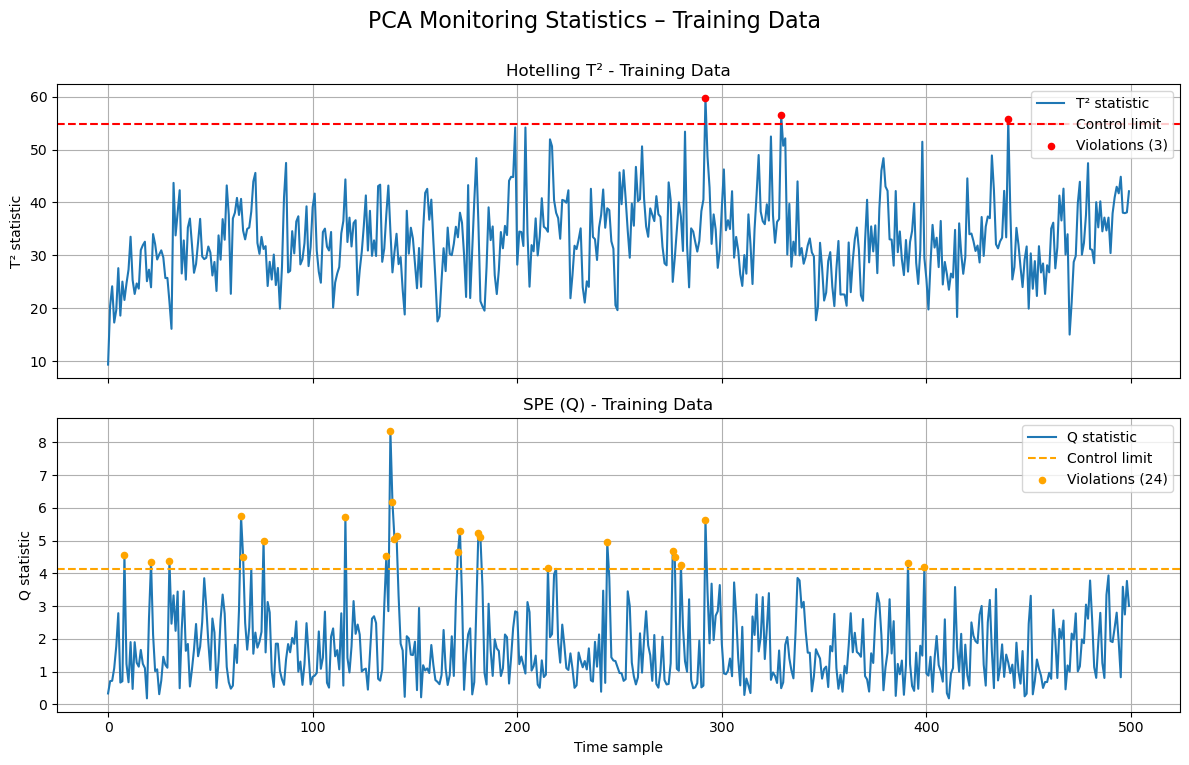

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle("PCA Monitoring Statistics – Training Data", fontsize=16, y=0.95)

# ---------- T² statistic ----------
axes[0].plot(T2_train, label="T² statistic")
axes[0].axhline(T2_limit, color='r', linestyle='--', label="Control limit")
T2_violation_indices = np.where(T2_train > T2_limit)[0]
axes[0].scatter(
    T2_violation_indices,
    T2_train[T2_train > T2_limit],
    s=20,
    color='red',
    label=f'Violations ({len(T2_violation_indices)})',
    zorder=5
)
axes[0].set_title("Hotelling T² - Training Data")
axes[0].set_ylabel("T² statistic")
axes[0].grid(True)
axes[0].legend()

# ---------- Q statistic ----------
axes[1].plot(Q_train, label="Q statistic")
axes[1].axhline(Q_limit, color='orange', linestyle='--', label="Control limit")
Q_violation_indices = np.where(Q_train > Q_limit)[0]
axes[1].scatter(
    Q_violation_indices,
    Q_train[Q_train > Q_limit],
    s=20,
    color='orange',
    label=f'Violations ({len(Q_violation_indices)})',
    zorder=5
)
axes[1].set_title("SPE (Q) - Training Data")
axes[1].set_xlabel("Time sample")
axes[1].set_ylabel("Q statistic")
axes[1].grid(True)
axes[1].legend()

# Τελειώματα
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(os.path.join(TRAIN_DIR, "PCA_Monitoring_Statistics_Training_Data.png"),
            dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

In [41]:
def plot_PCA_Monitoring_Statistics(T2_test, T2_limit, Q_test, Q_limit, FAULT_DIR, FAULT_NAME="Fault"):
    """
    Creates and saves a PCA monitoring plot for T² and Q statistics for a given fault.
    """
    
    # Create figure and axes
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f"PCA Monitoring Statistics – Test Data ({FAULT_NAME})", fontsize=16, y=0.95)
    
    # ------------------- T² subplot -------------------
    axes[0].plot(T2_test, label="T² statistic")
    axes[0].axhline(T2_limit, color='r', linestyle='--', label="Control limit")

    violations_T2_idx = np.where(T2_test > T2_limit)[0]
    violations_T2_val = T2_test[violations_T2_idx]

    diff_idx = np.diff(violations_T2_idx)
    split_points = np.where(diff_idx > 1)[0]

    # Scatter plot for isolated violations
    start_idx = 0
    for sp in split_points:
        idxs = violations_T2_idx[start_idx:sp+1]
        vals = violations_T2_val[start_idx:sp+1]
        if len(idxs) == 1:
            axes[0].scatter(idxs, vals, s=25, color='red', edgecolor='black', zorder=10)
        start_idx = sp + 1

    if start_idx < len(violations_T2_idx):
        idxs = violations_T2_idx[start_idx:]
        vals = violations_T2_val[start_idx:]
        if len(idxs) == 1:
            axes[0].scatter(idxs, vals, s=25, color='red', edgecolor='black', zorder=10)

    # Highlight consecutive violations
    start_idx = 0
    for sp in split_points:
        idxs = violations_T2_idx[start_idx:sp+1]
        if len(idxs) > 1:
            axes[0].axvspan(idxs[0]-0.5, idxs[-1]+0.5, color='red', alpha=0.2)
        start_idx = sp + 1

    idxs = violations_T2_idx[start_idx:]
    if len(idxs) > 1:
        axes[0].axvspan(idxs[0]-0.5, idxs[-1]+0.5, color='red', alpha=0.2)

    axes[0].scatter([], [], color='red', label=f'Violations ({len(violations_T2_idx)})')
    axes[0].set_title(f"Hotelling T² - Test Data ({FAULT_NAME})")
    axes[0].set_xlabel("Time sample")
    axes[0].set_ylabel("T² statistic")
    axes[0].grid(True)
    axes[0].legend()
    
    # ------------------- Q subplot -------------------
    axes[1].plot(Q_test, label="Q statistic")
    axes[1].axhline(Q_limit, color='orange', linestyle='--', label="Control limit")

    violations_Q_idx = np.where(Q_test > Q_limit)[0]
    violations_Q_val = Q_test[violations_Q_idx]

    diff_idx = np.diff(violations_Q_idx)
    split_points = np.where(diff_idx > 1)[0]

    # Scatter plot for isolated violations
    start_idx = 0
    for sp in split_points:
        idxs = violations_Q_idx[start_idx:sp+1]
        vals = violations_Q_val[start_idx:sp+1]
        if len(idxs) == 1:
            axes[1].scatter(idxs, vals, s=25, color='orange', edgecolor='black', zorder=10)
        start_idx = sp + 1

    if start_idx < len(violations_Q_idx):
        idxs = violations_Q_idx[start_idx:]
        vals = violations_Q_val[start_idx:]
        if len(idxs) == 1:
            axes[1].scatter(idxs, vals, s=25, color='orange', edgecolor='black', zorder=10)
            
    # Highlight consecutive violations
    start_idx = 0
    for sp in split_points:
        idxs = violations_Q_idx[start_idx:sp+1]
        if len(idxs) > 1:
            axes[1].axvspan(idxs[0]-0.5, idxs[-1]+0.5, color='orange', alpha=0.2)
        start_idx = sp + 1

    idxs = violations_Q_idx[start_idx:]
    if len(idxs) > 1:
        axes[1].axvspan(idxs[0]-0.5, idxs[-1]+0.5, color='orange', alpha=0.2)

    axes[1].scatter([], [], color='orange', label=f'Violations ({len(violations_Q_idx)})')
    axes[1].set_title(f"SPE (Q) - Test Data ({FAULT_NAME})")
    axes[1].set_xlabel("Time sample")
    axes[1].set_ylabel("Q statistic")
    axes[1].grid(True)
    axes[1].legend()
    
    # ------------------- Final adjustments -------------------
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Create folder if it does not exist
    os.makedirs(FAULT_DIR, exist_ok=True)
    filename = os.path.join(FAULT_DIR, f"PCA_Monitoring_Statistics_{FAULT_NAME}.png")
    # Save and show the figure
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


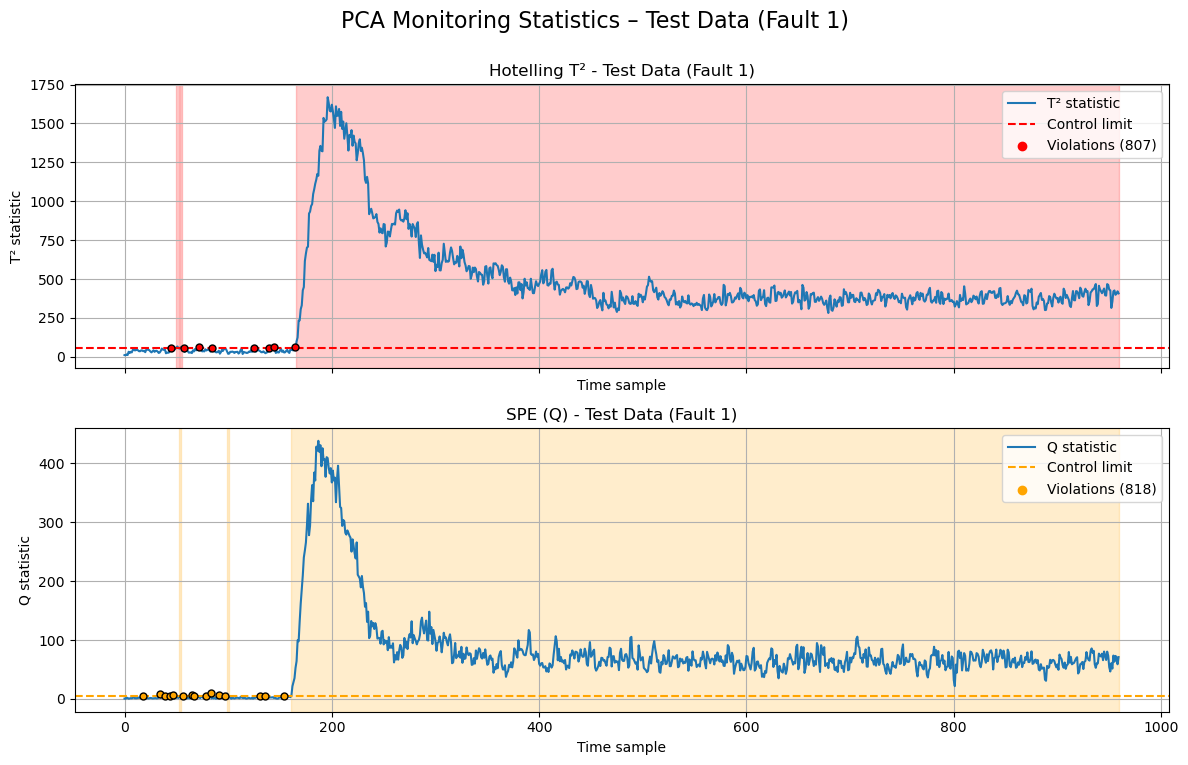

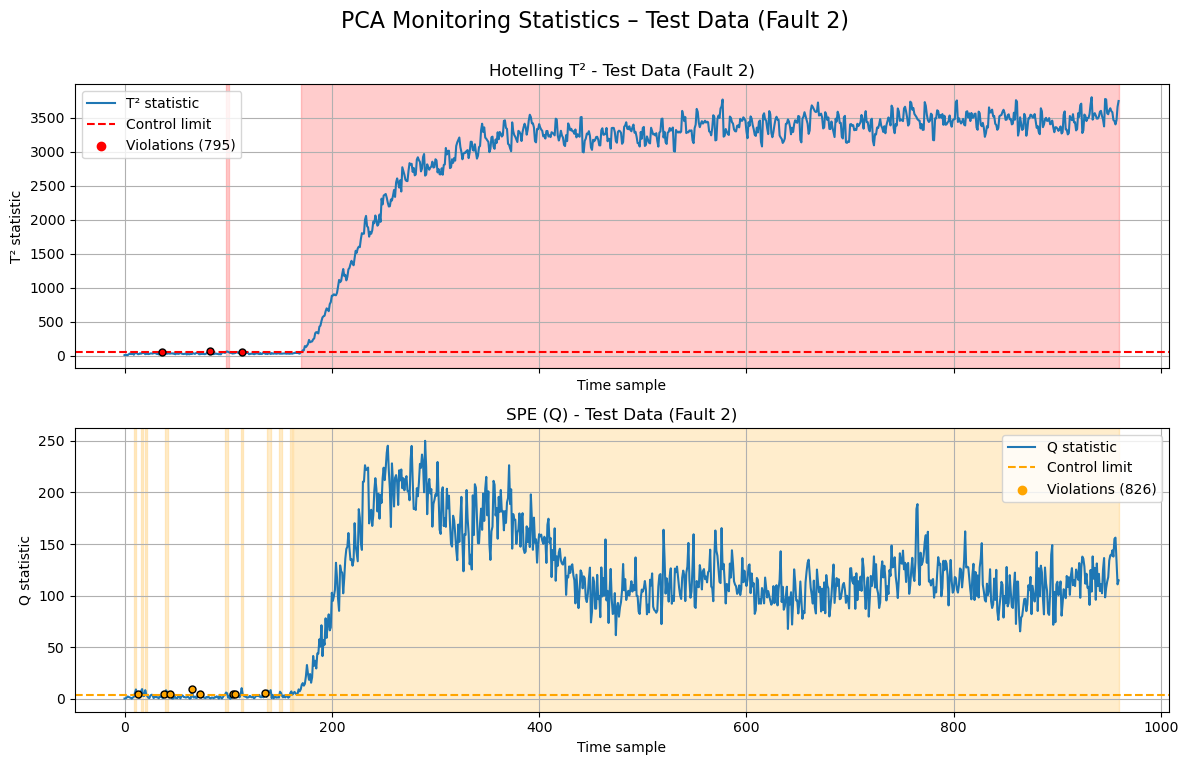

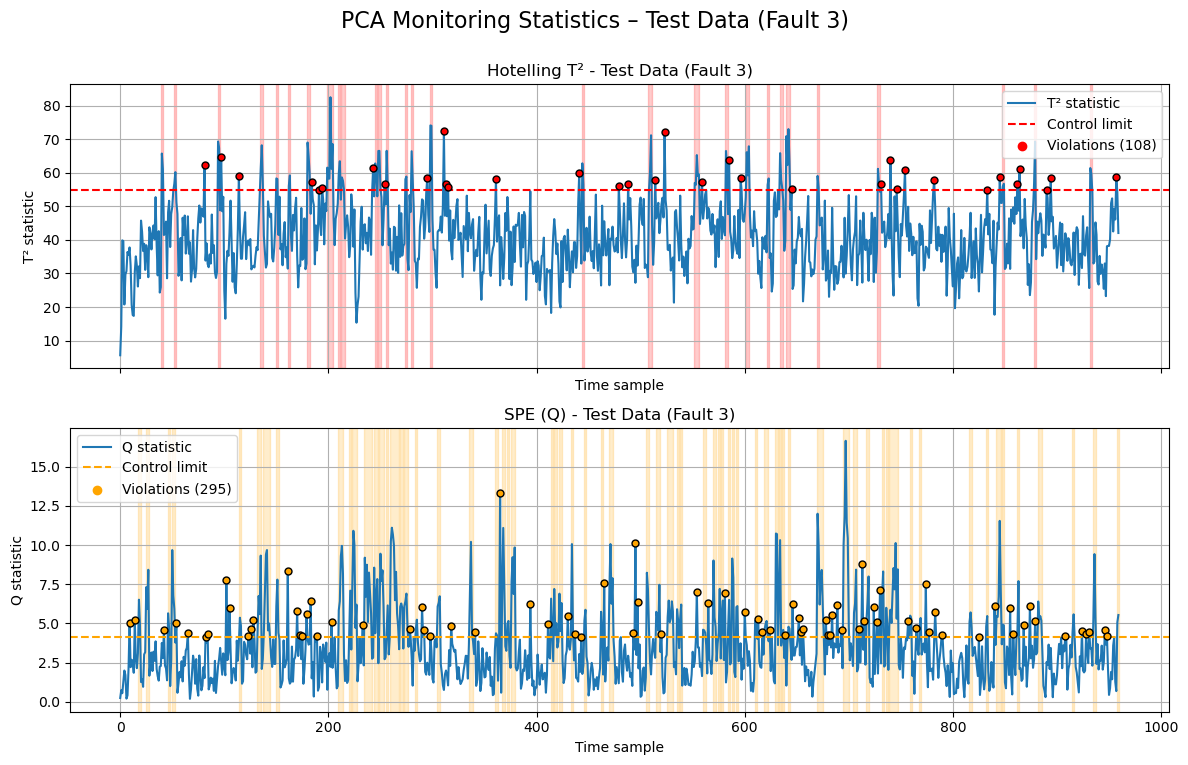

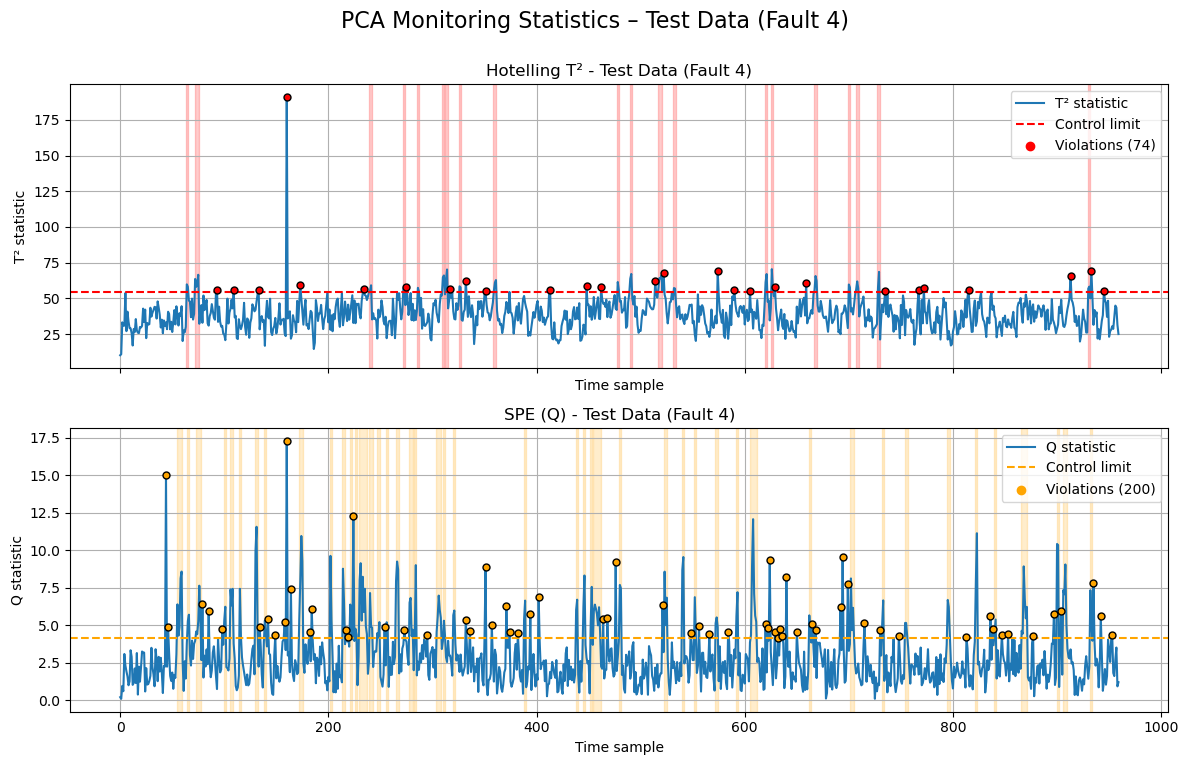

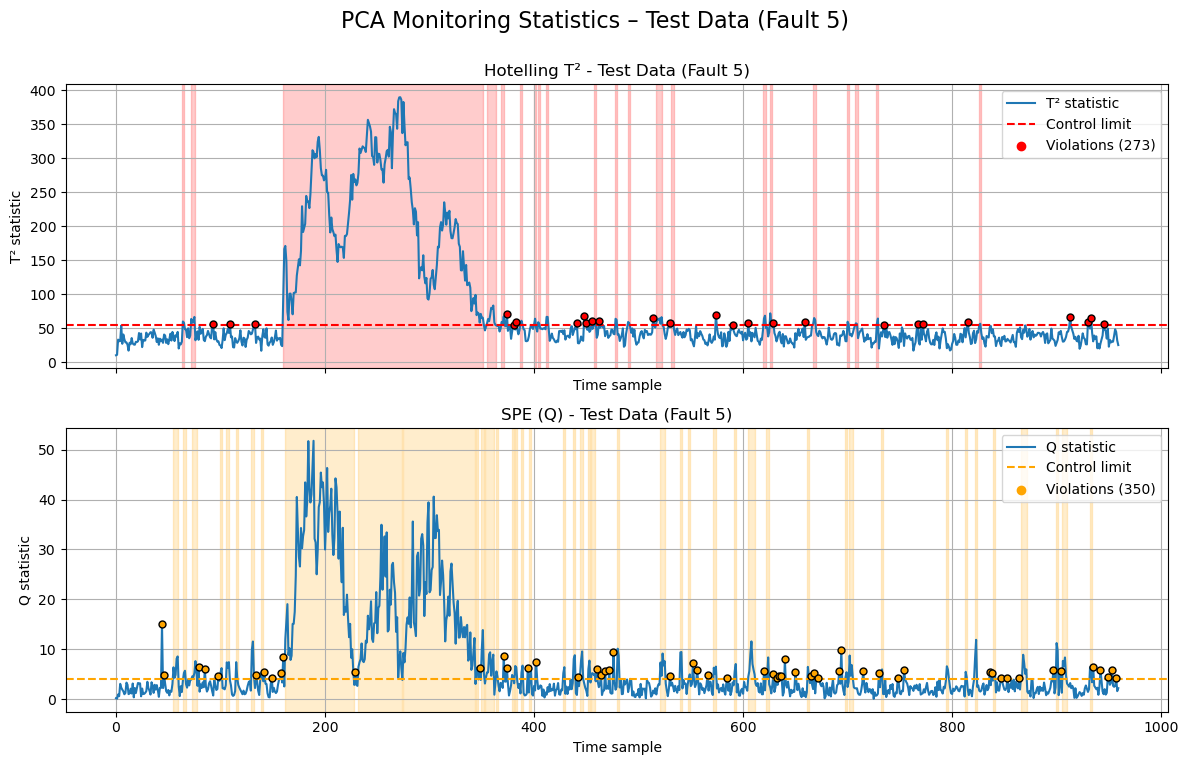

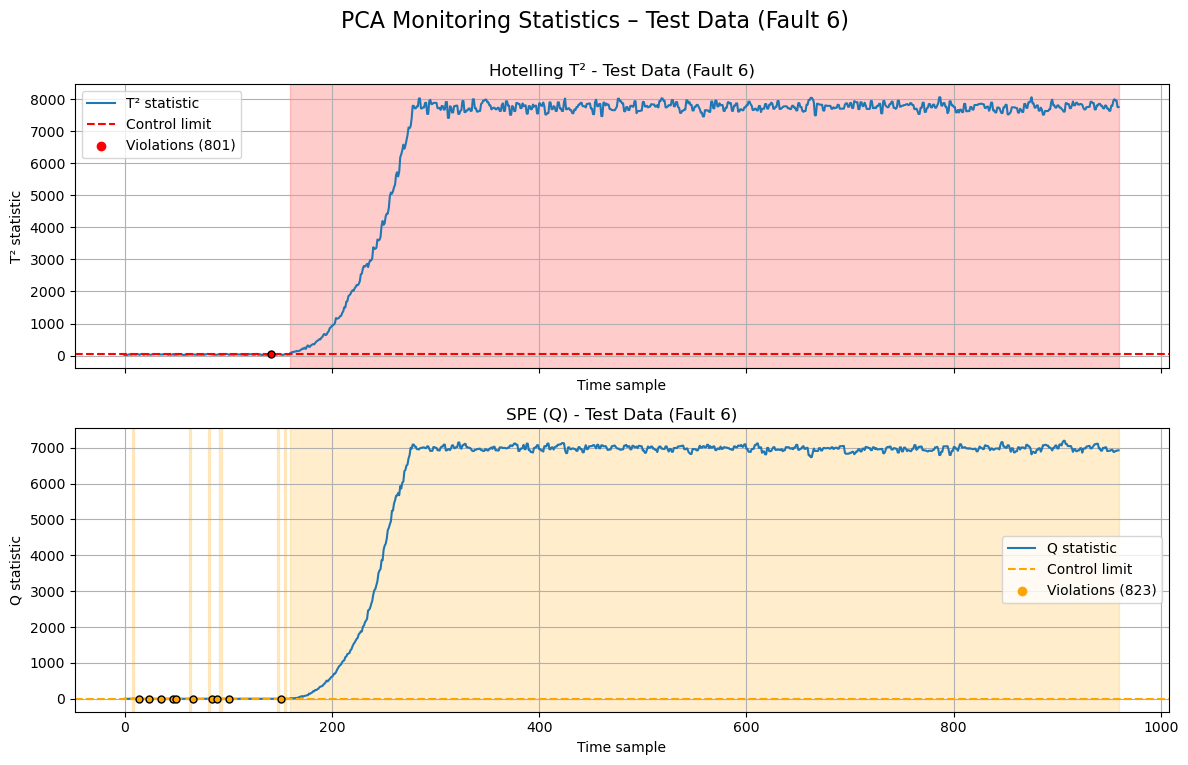

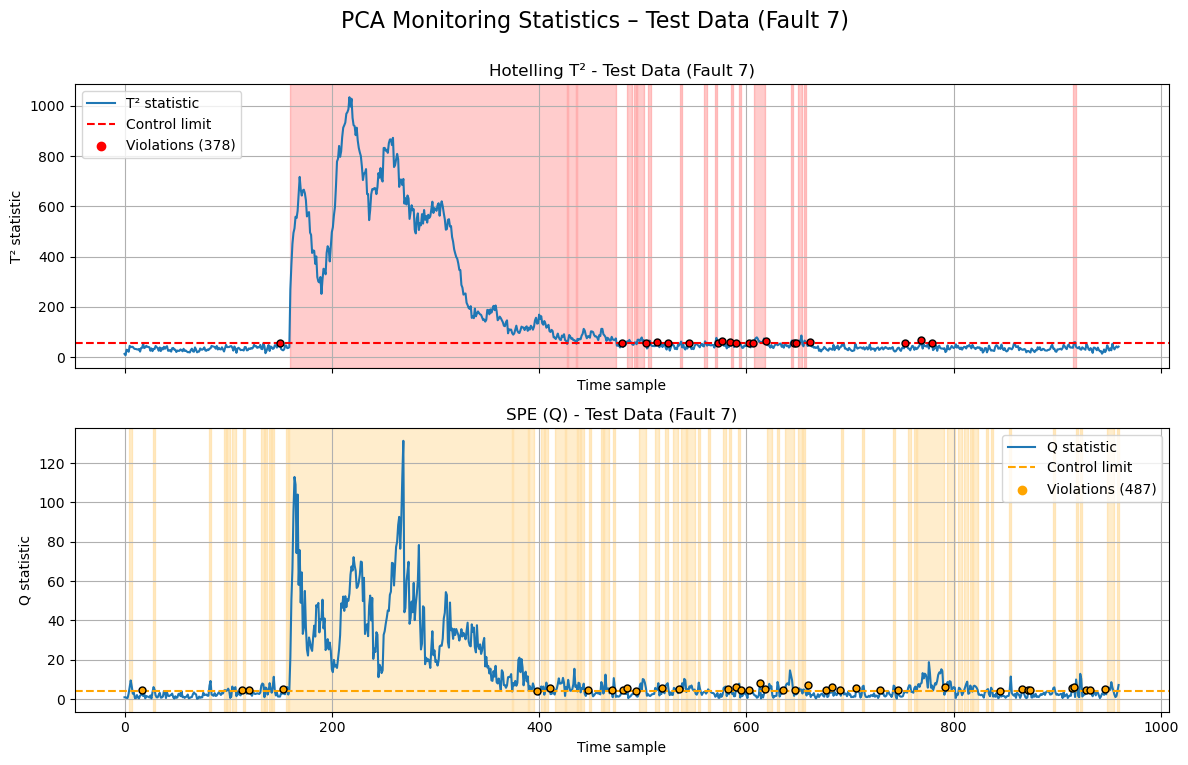

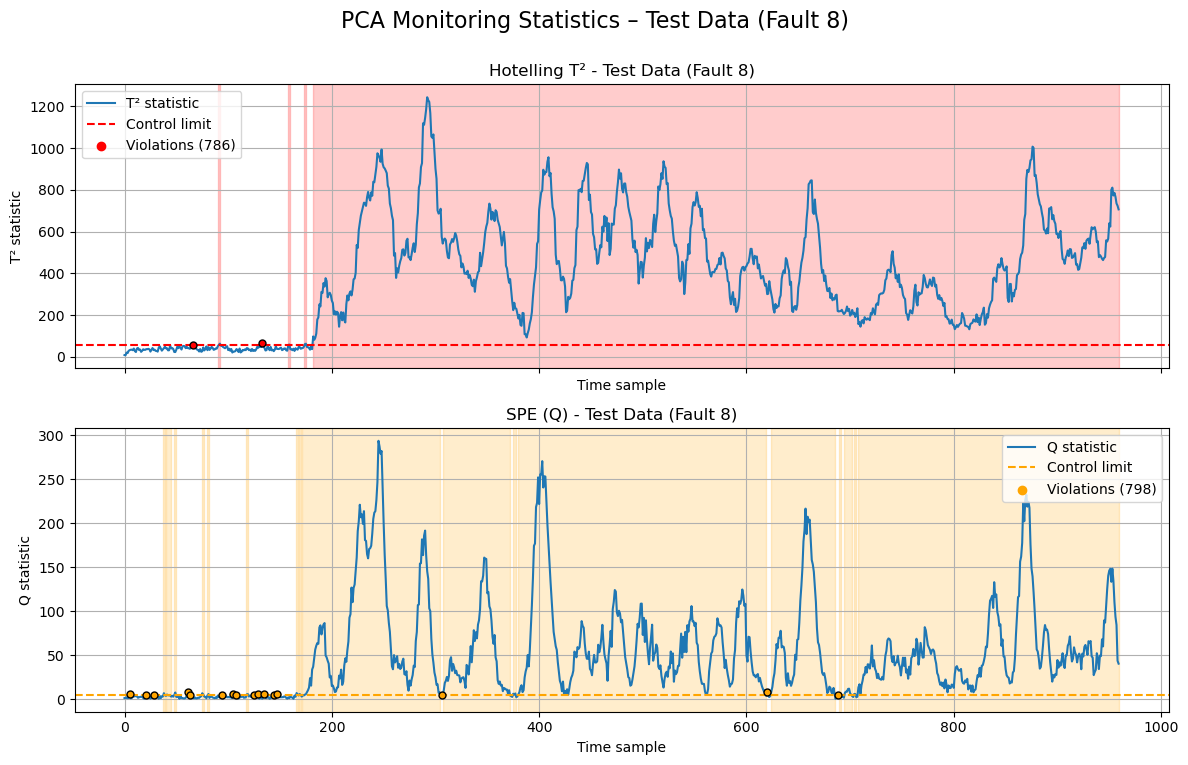

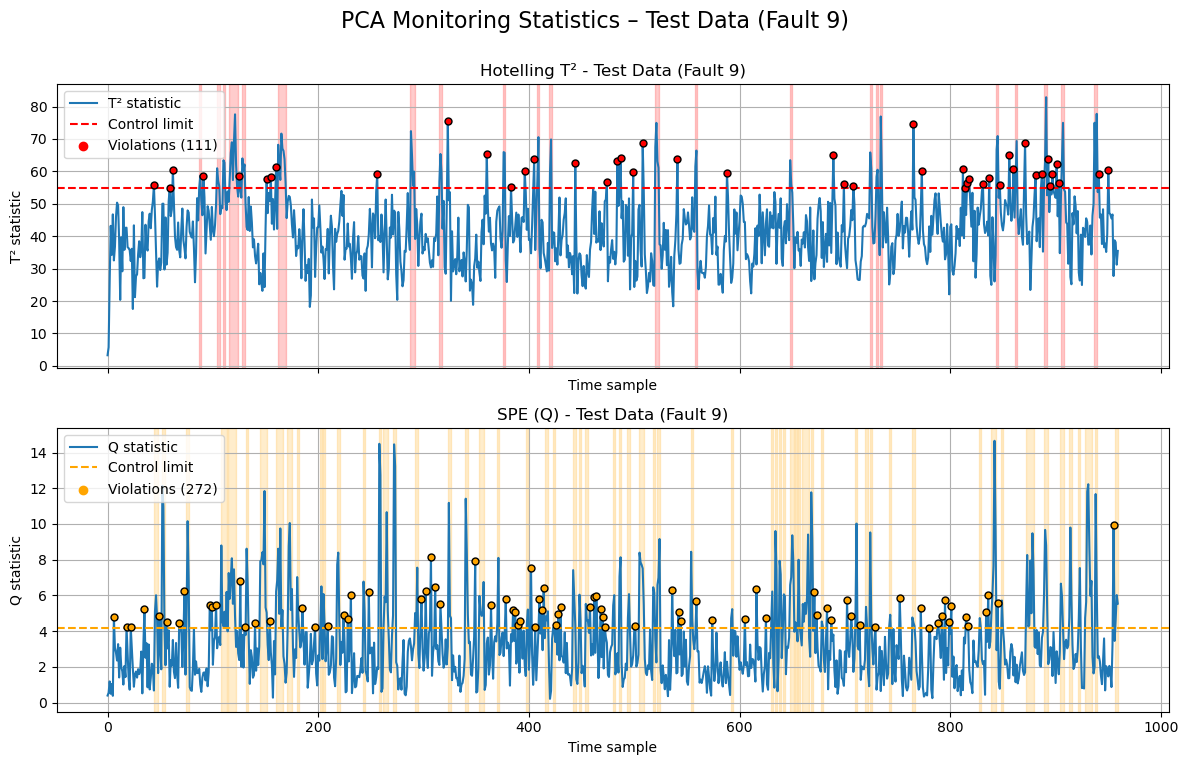

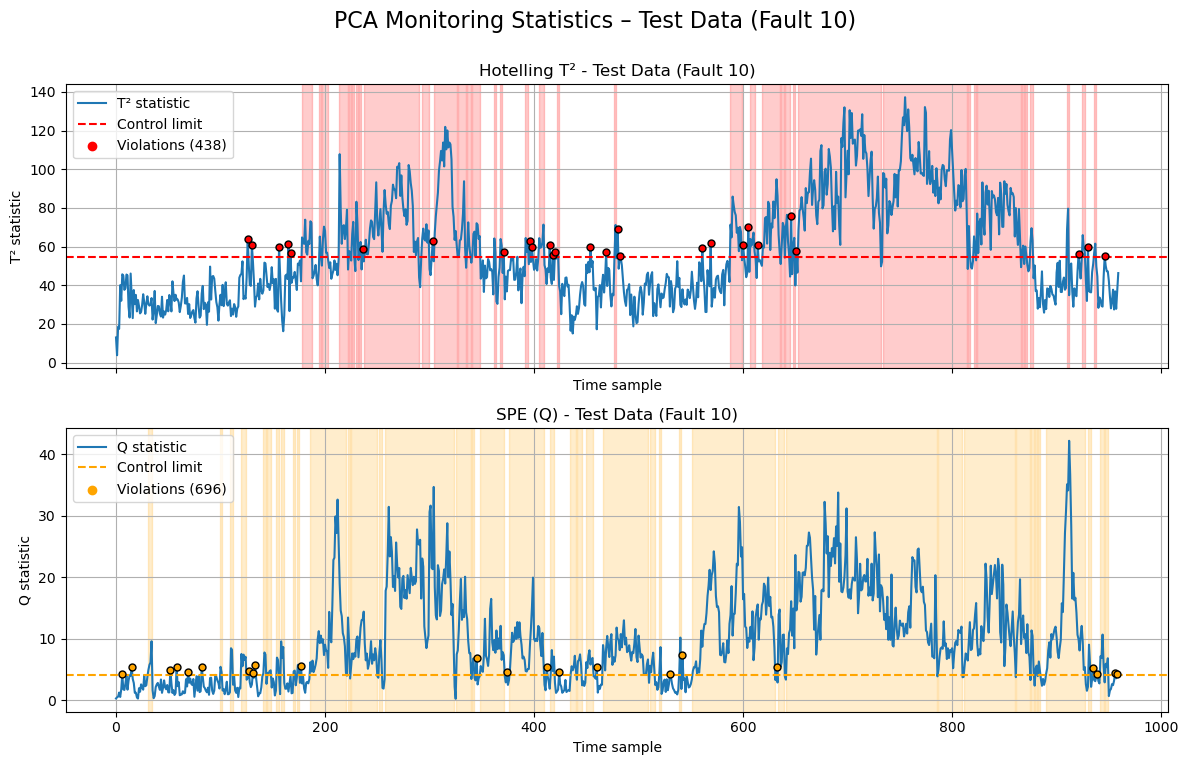

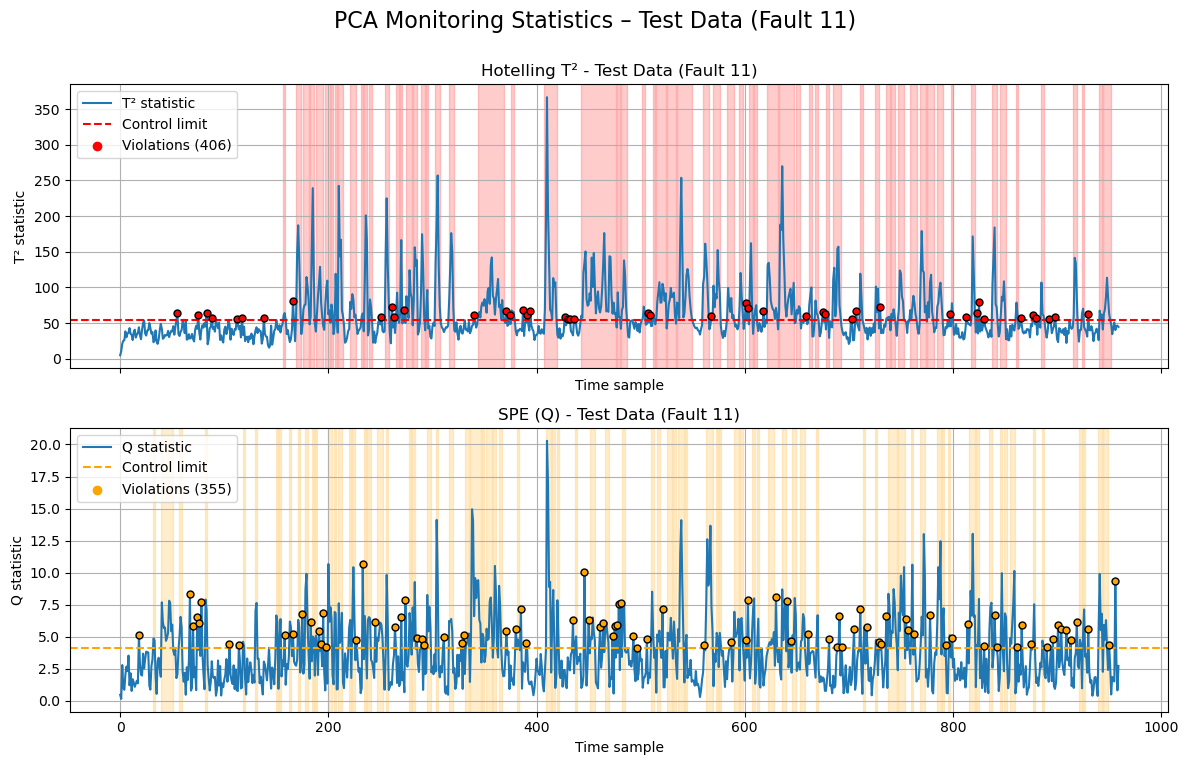

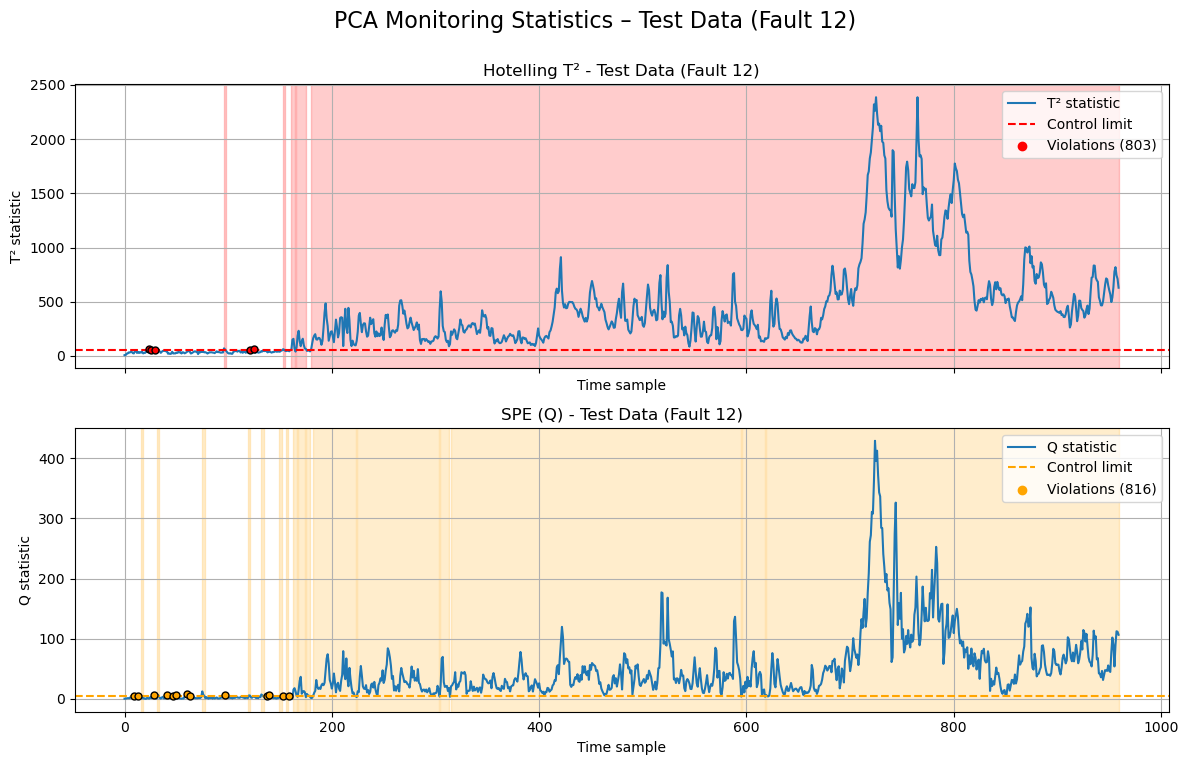

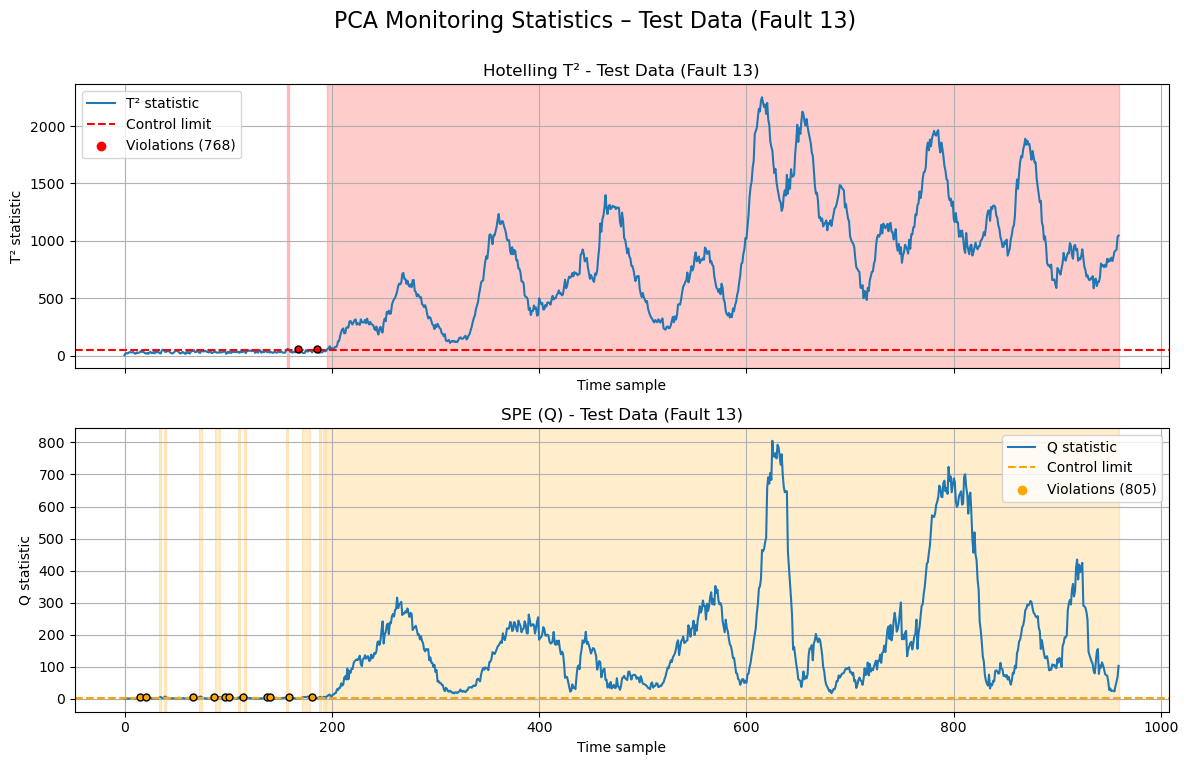

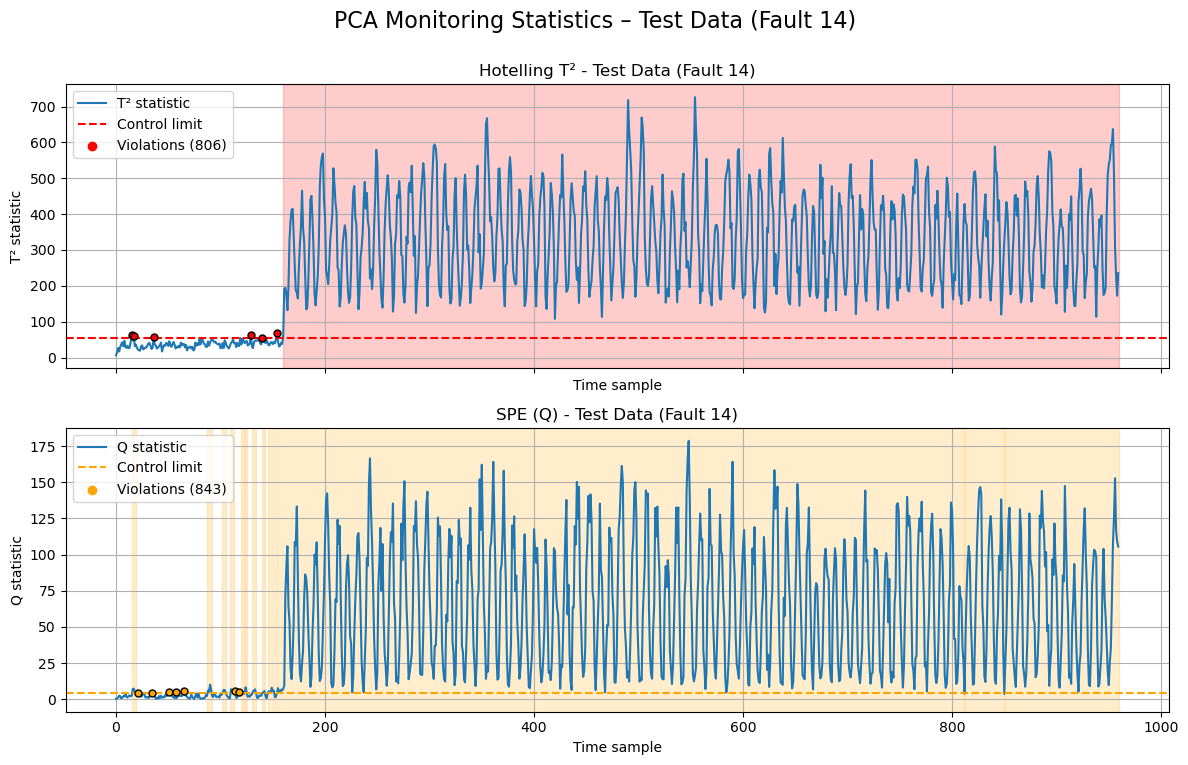

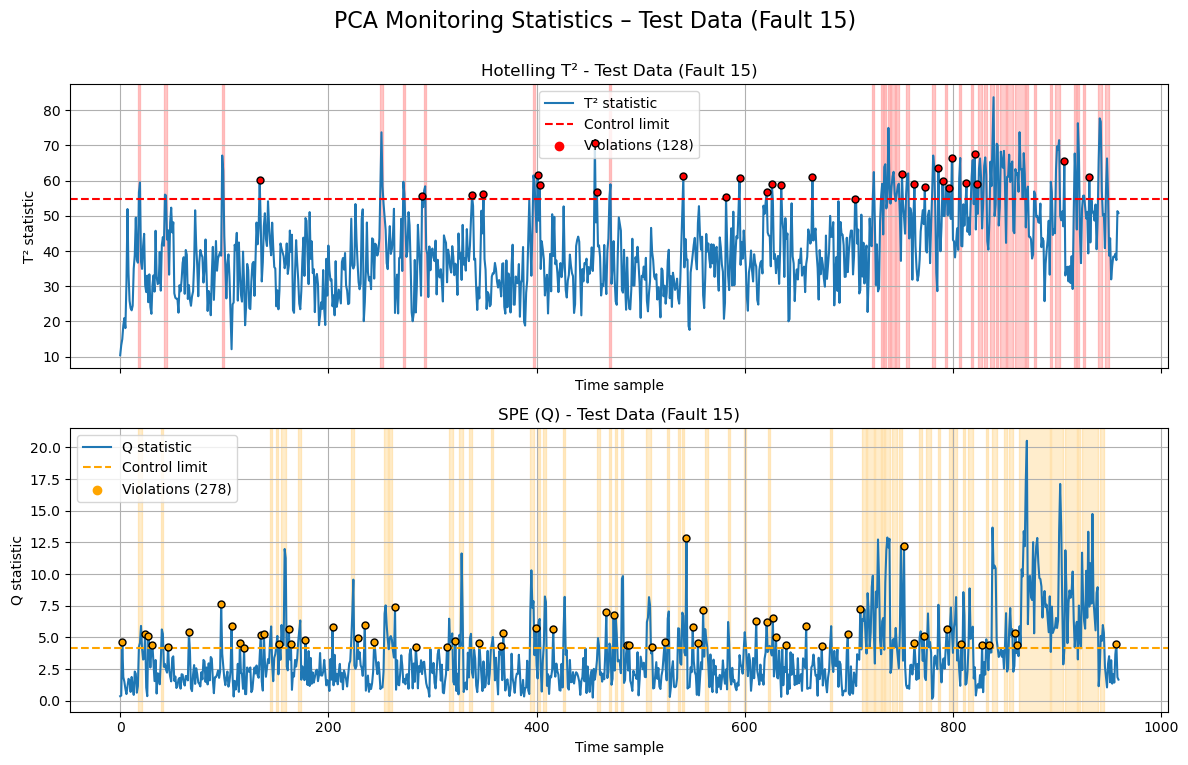

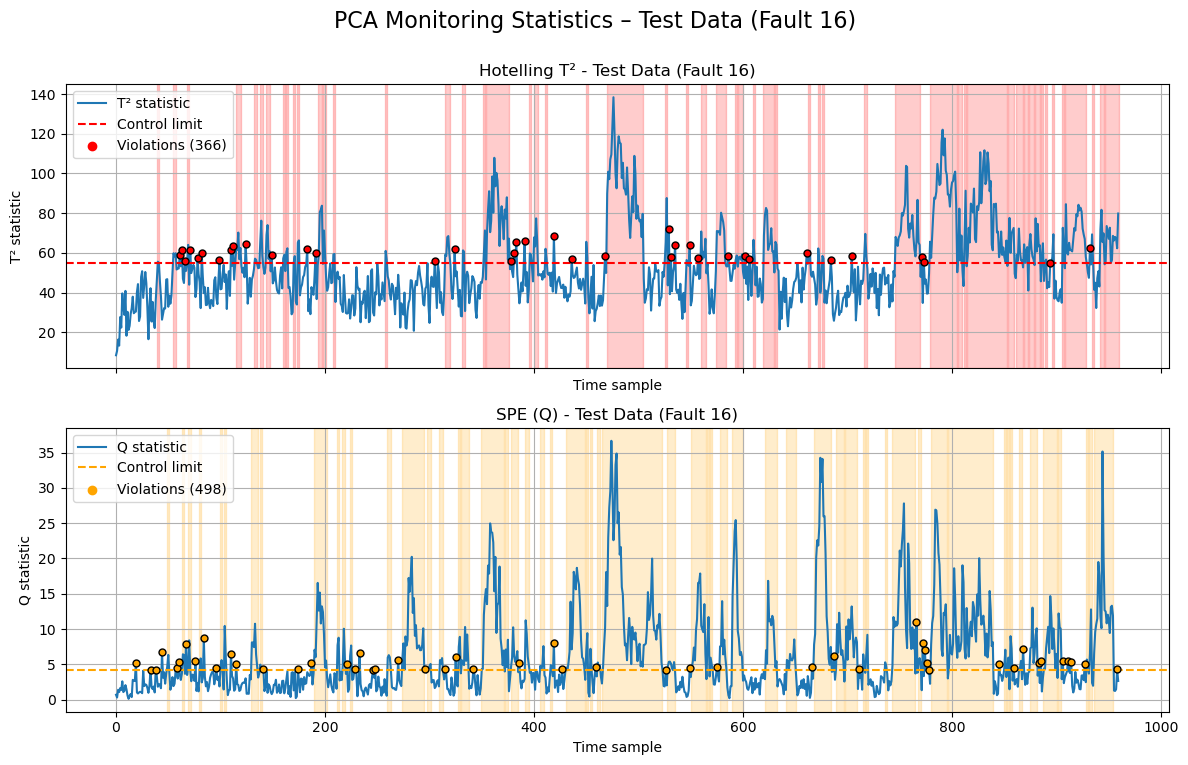

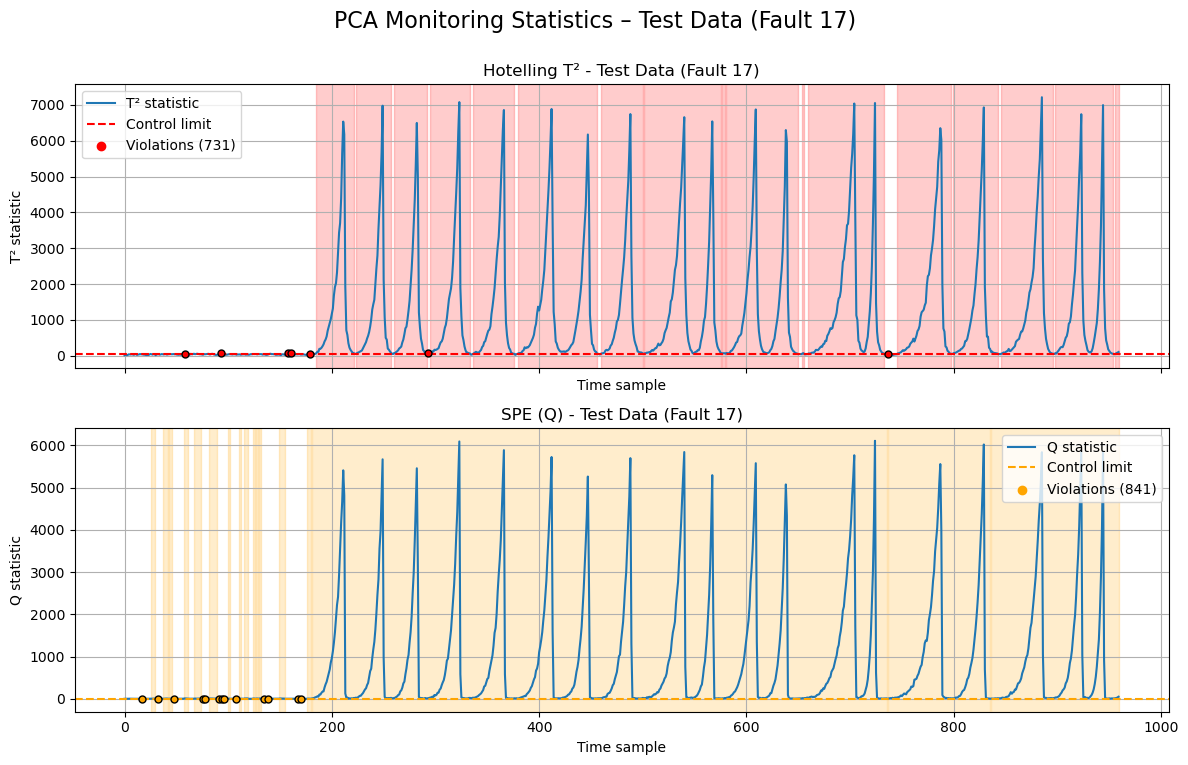

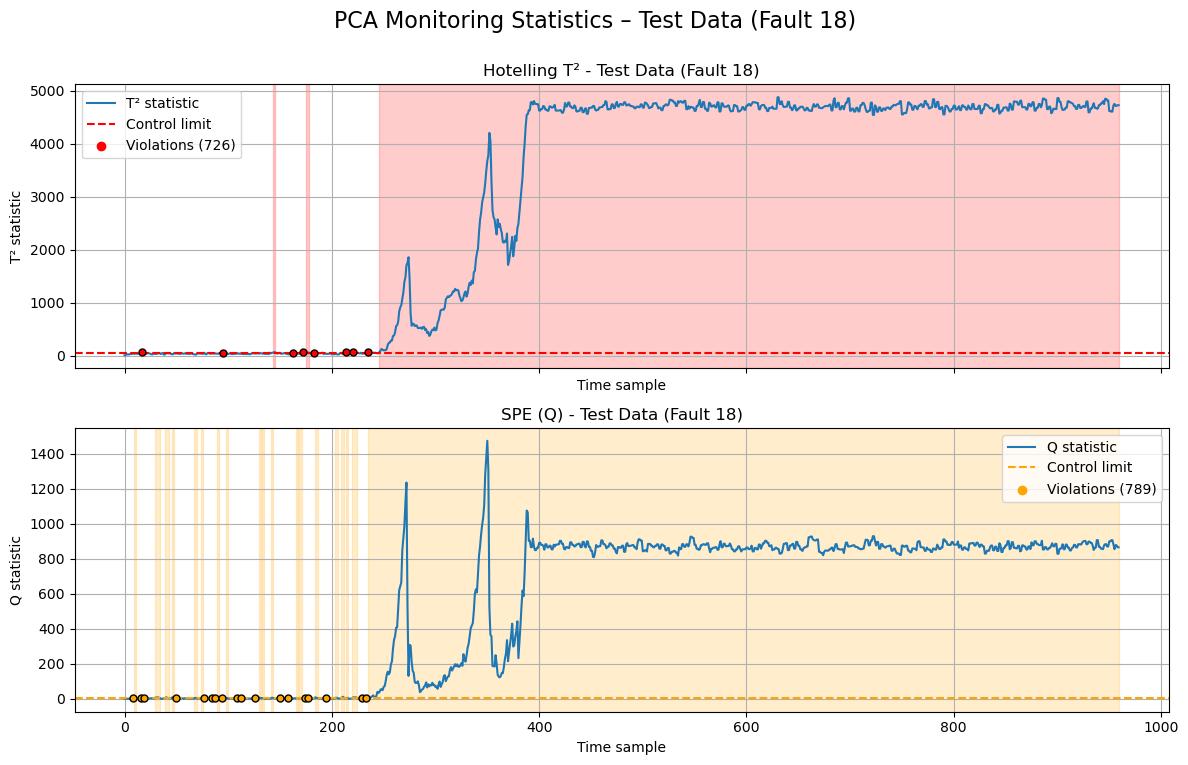

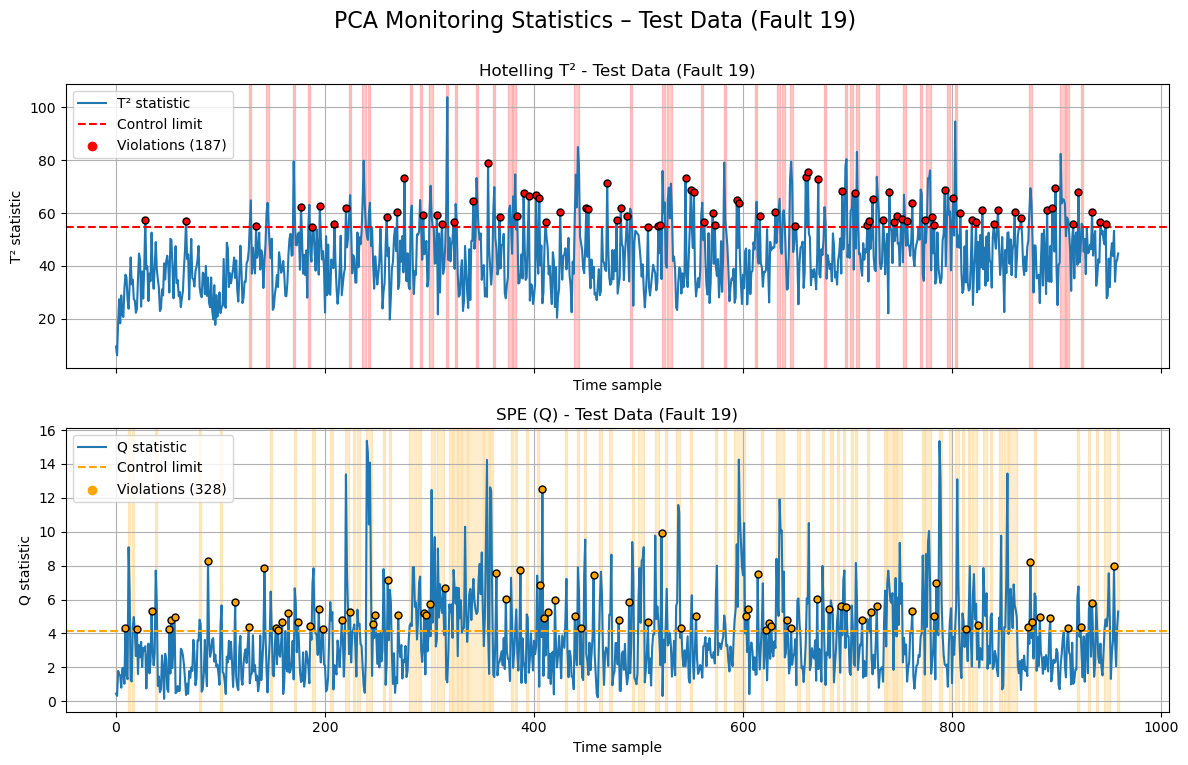

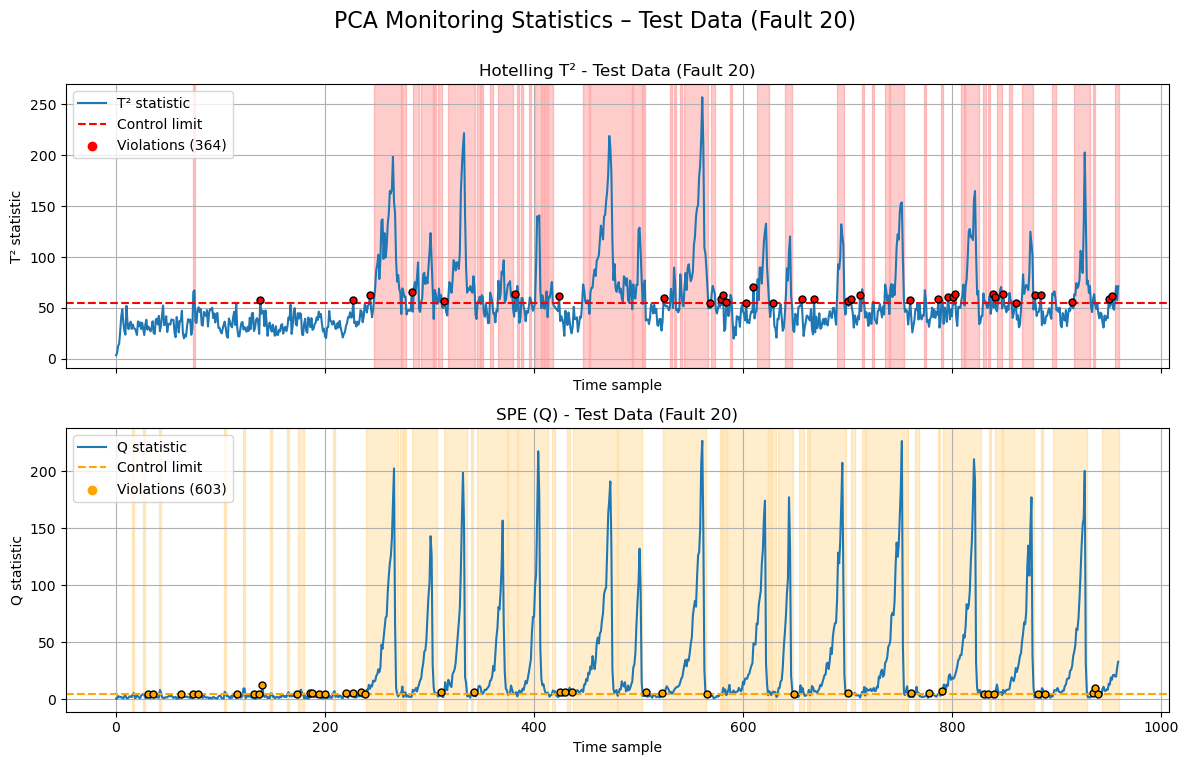

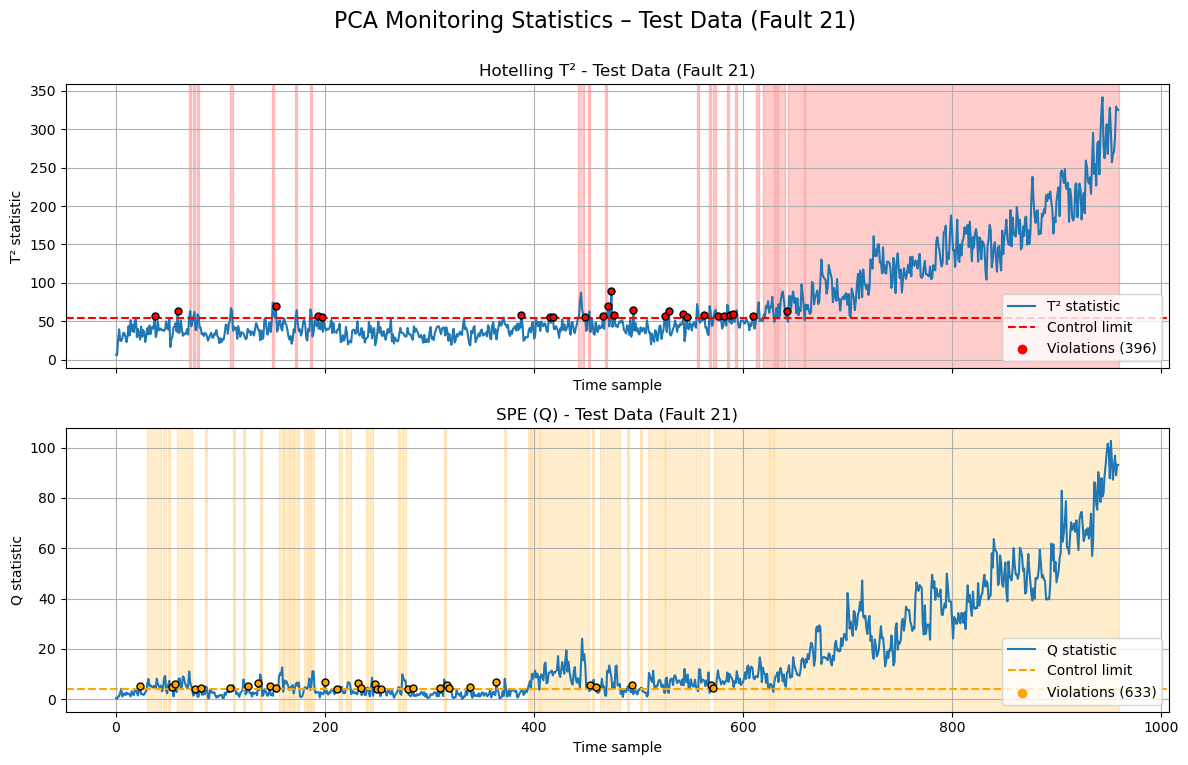

In [42]:
T2_tests = { 
    "Fault 1": T2_test_1,
    "Fault 2": T2_test_2,
    "Fault 3": T2_test_3,
    "Fault 4": T2_test_4,
    "Fault 5": T2_test_5,
    "Fault 6": T2_test_6,
    "Fault 7": T2_test_7,
    "Fault 8": T2_test_8,
    "Fault 9": T2_test_9,
    "Fault 10": T2_test_10,
    "Fault 11": T2_test_11,
    "Fault 12": T2_test_12,
    "Fault 13": T2_test_13,
    "Fault 14": T2_test_14,
    "Fault 15": T2_test_15,
    "Fault 16": T2_test_16,
    "Fault 17": T2_test_17,
    "Fault 18": T2_test_18,
    "Fault 19": T2_test_19,
    "Fault 20": T2_test_20,
    "Fault 21": T2_test_21
}

Q_tests = {
    "Fault 1": Q_test_1,
    "Fault 2": Q_test_2,
    "Fault 3": Q_test_3,
    "Fault 4": Q_test_4,
    "Fault 5": Q_test_5,
    "Fault 6": Q_test_6,
    "Fault 7": Q_test_7,
    "Fault 8": Q_test_8,
    "Fault 9": Q_test_9,
    "Fault 10": Q_test_10,
    "Fault 11": Q_test_11,
    "Fault 12": Q_test_12,
    "Fault 13": Q_test_13,
    "Fault 14": Q_test_14,
    "Fault 15": Q_test_15,
    "Fault 16": Q_test_16,
    "Fault 17": Q_test_17,
    "Fault 18": Q_test_18,
    "Fault 19": Q_test_19,
    "Fault 20": Q_test_20,
    "Fault 21": Q_test_21
}



for fault_name in T2_tests.keys():
    T2_test = T2_tests[fault_name]
    Q_test = Q_tests[fault_name]
    # Create paths
    FAULT_DIR = os.path.join(BASE_DIR, "figures", fault_name)
    
    plot_PCA_Monitoring_Statistics(
        T2_test=T2_test,
        T2_limit=T2_limit,
        Q_test=Q_test,
        Q_limit=Q_limit,
        FAULT_DIR=FAULT_DIR,
        FAULT_NAME=fault_name
    )


---

# __Autoencoder__

## __Phase~I__

##  Χτίζω τον Autoencoder και τον εκπαιδεύω στα train data

In [23]:
def build_autoencoder(X_train_scaled):
    """
    Creates an autoencoder model and returns it.
    """
    input_dim = X_train_scaled.shape[1]  # use the number of features from X_train_scaled
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(32, activation='relu', kernel_initializer=initializer)(input_layer)
    encoded = Dense(16, activation='relu', kernel_initializer=initializer)(encoded)  # latent representation

    # Decoder
    decoded = Dense(32, activation='relu', kernel_initializer=initializer)(encoded)
    output_layer = Dense(input_dim, activation='linear', kernel_initializer=initializer)(decoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder

In [24]:
def train_autoencoder(X_train_scaled, autoencoder):
    """
    Trains the autoencoder on the scaled training data.
    """
    history = autoencoder.fit(X_train_scaled,
                              X_train_scaled,
                              epochs=20,
                              batch_size=32,
                              validation_split=0.1,
                              shuffle=True)
    return autoencoder, history

In [25]:
autoencoder = build_autoencoder(X_train_scaled)
autoencoder, history = train_autoencoder(X_train_scaled, autoencoder)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.0629 - val_loss: 1.1653
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9924 - val_loss: 1.1507
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9668 - val_loss: 1.1393
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9488 - val_loss: 1.1228
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9290 - val_loss: 1.0952
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9054 - val_loss: 1.0600
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8792 - val_loss: 1.0195
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8532 - val_loss: 0.9804
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8304 - val_loss: 0.9490
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8113 - val_loss: 0.9253
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7947 - val_loss: 0.9038
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7

## Σφάλμα ανακατασκευής και τα όριά του

In [26]:
def calculate_L_train(X_train_scaled, autoencoder):
    """
    Computes the reconstruction error for training data and calculates control limits.
    """
    # Predict/reconstruct the training data
    X_train_hat = autoencoder.predict(X_train_scaled)

    # Compute reconstruction error (squared error per sample)
    L_train = np.mean((X_train_scaled - X_train_hat)**2, axis=1)
    
    # Compute Phase I control limits
    L_mean = np.mean(L_train)
    L_std = np.std(L_train, ddof=1)
    CL = L_mean                   # Center line
    UCL = L_mean + 3 * L_std      # Upper control limit
    LCL = max(0.0, L_mean - 3 * L_std)  # Lower control limit, not below 0
    
    return L_train, CL, UCL, LCL

In [27]:
L_train, CL, UCL, LCL = calculate_L_train(X_train_scaled, autoencoder)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [28]:
print("RE limits:", "\n",
       "LCL:", LCL, "\n",
       "CL:", CL, "\n",
       "UCL:", UCL)

RE limits: 
 LCL: 0.1420713977853605 
 CL: 0.6823882589082004 
 UCL: 1.2227051200310404


## __Phase~II__

In [29]:
def compute_L_test(X_test_scaled, autoencoder):
    """
    Computes the reconstruction error (L) for the test data using the trained autoencoder.
    """
    # Predict/reconstruct the test data
    X_test_hat = autoencoder.predict(X_test_scaled)
    
    # Compute reconstruction error (squared error per sample)
    L_test = np.mean((X_test_scaled - X_test_hat)**2, axis=1)

    return L_test

In [30]:
L_test_1 = compute_L_test(X_test_1_scaled, autoencoder)
L_test_2 = compute_L_test(X_test_2_scaled, autoencoder)
L_test_3 = compute_L_test(X_test_3_scaled, autoencoder)
L_test_4 = compute_L_test(X_test_4_scaled, autoencoder)
L_test_5 = compute_L_test(X_test_5_scaled, autoencoder)
L_test_6 = compute_L_test(X_test_6_scaled, autoencoder)
L_test_7 = compute_L_test(X_test_7_scaled, autoencoder)
L_test_8 = compute_L_test(X_test_8_scaled, autoencoder)
L_test_9 = compute_L_test(X_test_9_scaled, autoencoder)
L_test_10 = compute_L_test(X_test_10_scaled, autoencoder)
L_test_11 = compute_L_test(X_test_11_scaled, autoencoder)
L_test_12 = compute_L_test(X_test_12_scaled, autoencoder)
L_test_13 = compute_L_test(X_test_13_scaled, autoencoder)
L_test_14 = compute_L_test(X_test_14_scaled, autoencoder)
L_test_15 = compute_L_test(X_test_15_scaled, autoencoder)
L_test_16 = compute_L_test(X_test_16_scaled, autoencoder)
L_test_17 = compute_L_test(X_test_17_scaled, autoencoder)
L_test_18 = compute_L_test(X_test_18_scaled, autoencoder)
L_test_19 = compute_L_test(X_test_19_scaled, autoencoder)
L_test_20 = compute_L_test(X_test_20_scaled, autoencoder)
L_test_21 = compute_L_test(X_test_21_scaled, autoencoder)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


---

## Μετρικές για τα διαγράμματα

In [131]:
def compute_detection_stats_RE(L, UCL, LCL, fault_label = None):
    """
    Computes detection statistics based on reconstruction error (L) and control limits.
    """
    AE_detection_rate = np.mean((L > UCL) | (L < LCL))
    AE_num_violations = np.sum((L > UCL) | (L < LCL))

    # Create a DataFrame summarizing the results    
    df = pd.DataFrame([{
        "Fault": fault_label,
        "AE_detection_rate": AE_detection_rate,
        "AE_num_violations": AE_num_violations
    }])

    return df

In [132]:
detection_stats_train_RE = compute_detection_stats_RE(L_train, UCL, LCL, fault_label = "train")
detection_stats_train_RE = detection_stats_train_RE.drop("Fault", axis = 1)

detection_stats_fault_1_RE = compute_detection_stats_RE(L_test_1, UCL, LCL, fault_label=1)
detection_stats_fault_2_RE = compute_detection_stats_RE(L_test_2, UCL, LCL, fault_label=2)
detection_stats_fault_3_RE = compute_detection_stats_RE(L_test_3, UCL, LCL, fault_label=3)
detection_stats_fault_4_RE = compute_detection_stats_RE(L_test_4, UCL, LCL, fault_label=4)
detection_stats_fault_5_RE = compute_detection_stats_RE(L_test_5, UCL, LCL, fault_label=5)
detection_stats_fault_6_RE = compute_detection_stats_RE(L_test_6, UCL, LCL, fault_label=6)
detection_stats_fault_7_RE = compute_detection_stats_RE(L_test_7, UCL, LCL, fault_label=7)
detection_stats_fault_8_RE = compute_detection_stats_RE(L_test_8, UCL, LCL, fault_label=8)
detection_stats_fault_9_RE = compute_detection_stats_RE(L_test_9, UCL, LCL, fault_label=9)
detection_stats_fault_10_RE = compute_detection_stats_RE(L_test_10, UCL, LCL, fault_label=10)
detection_stats_fault_11_RE = compute_detection_stats_RE(L_test_11, UCL, LCL, fault_label=11)
detection_stats_fault_12_RE = compute_detection_stats_RE(L_test_12, UCL, LCL, fault_label=12)
detection_stats_fault_13_RE = compute_detection_stats_RE(L_test_13, UCL, LCL, fault_label=13)
detection_stats_fault_14_RE = compute_detection_stats_RE(L_test_14, UCL, LCL, fault_label=14)
detection_stats_fault_15_RE = compute_detection_stats_RE(L_test_15, UCL, LCL, fault_label=15)
detection_stats_fault_16_RE = compute_detection_stats_RE(L_test_16, UCL, LCL, fault_label=16)
detection_stats_fault_17_RE = compute_detection_stats_RE(L_test_17, UCL, LCL, fault_label=17)
detection_stats_fault_18_RE = compute_detection_stats_RE(L_test_18, UCL, LCL, fault_label=18)
detection_stats_fault_19_RE = compute_detection_stats_RE(L_test_19, UCL, LCL, fault_label=19)
detection_stats_fault_20_RE = compute_detection_stats_RE(L_test_20, UCL, LCL, fault_label=20)
detection_stats_fault_21_RE = compute_detection_stats_RE(L_test_21, UCL, LCL, fault_label=21)

In [133]:
dataframes_RE = [detection_stats_fault_1_RE, detection_stats_fault_2_RE, detection_stats_fault_3_RE, detection_stats_fault_4_RE, detection_stats_fault_5_RE,
                 detection_stats_fault_6_RE, detection_stats_fault_7_RE, detection_stats_fault_8_RE, detection_stats_fault_9_RE, detection_stats_fault_10_RE,
                 detection_stats_fault_11_RE, detection_stats_fault_12_RE, detection_stats_fault_13_RE, detection_stats_fault_14_RE, detection_stats_fault_15_RE,
                 detection_stats_fault_16_RE, detection_stats_fault_17_RE, detection_stats_fault_18_RE, detection_stats_fault_19_RE, detection_stats_fault_20_RE,
                 detection_stats_fault_21_RE]

In [134]:
detection_stats_faults_RE = pd.concat(dataframes_RE, axis=0)

In [135]:
detection_stats_faults_RE

Fault  AE_detection_rate  AE_num_violations
0      1           0.837500                804
0      2           0.825000                792
0      3           0.106250                102
0      4           0.091667                 88
0      5           0.279167                268
0      6           0.835417                802
0      7           0.380208                365
0      8           0.818750                786
0      9           0.136458                131
0     10           0.518750                498
0     11           0.364583                350
0     12           0.833333                800
0     13           0.802083                770
0     14           0.838542                805
0     15           0.110417                106
0     16           0.371875                357
0     17           0.794792                763
0     18           0.763542                733
0     19           0.180208                173
0     20           0.480208                461
0     21           0.451042                433

---

## Διαγράμματα

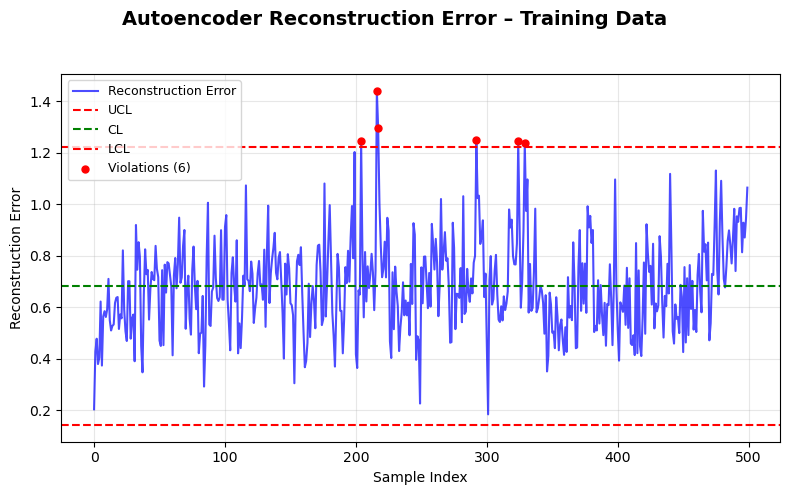

In [56]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Autoencoder Reconstruction Error – Training Data', fontsize=14, fontweight='bold')

# Plot reconstruction error line
ax.plot(L_train, alpha=0.7, color='blue', label='Reconstruction Error')

# Plot control limits
ax.axhline(UCL, color='r', linestyle='--', linewidth=1.5, label=f'UCL')
ax.axhline(CL, color='g', linestyle='--', linewidth=1.5, label=f'CL')
ax.axhline(LCL, color='r', linestyle='--', linewidth=1.5, label=f'LCL')

# Highlight violation points
train_violations = (L_train > UCL) | (L_train < LCL)
if train_violations.any():
    violation_indices = np.where(train_violations)[0]
    ax.scatter(violation_indices, L_train[train_violations],
               color='red', s=25, zorder=5, label=f'Violations ({len(violation_indices)})')
    
# Labels, legend, and grid
ax.set_xlabel('Sample Index')
ax.set_ylabel('Reconstruction Error')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
fig.savefig(os.path.join(TRAIN_DIR, "Autoencoder_Reconstruction_Error_Training_Data.png"),
            dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

In [59]:
def plot_RE_Monitoring(L_test, UCL, LCL, FAULT_DIR, FAULT_NAME="Fault"):
    """
    Creates and saves a reconstruction error (RE) monitoring plot for a given fault
    with isolated and consecutive violation highlighting.
    """

    fig, ax = plt.subplots(figsize=(12, 5))
    fig.suptitle(
        f"Autoencoder Reconstruction Error – Test Data ({FAULT_NAME})",
        fontsize=14, fontweight="bold"
    )

    # ------------------- RE plot -------------------
    ax.plot(L_test, color="darkorange", alpha=0.7, label="Reconstruction Error")

    # Control limits
    ax.axhline(UCL, color="red", linestyle="--", linewidth=1.5, label="UCL")
    ax.axhline(LCL, color="red", linestyle="--", linewidth=1.5, label="LCL")

    CL = (UCL + LCL) / 2
    ax.axhline(CL, color="green", linestyle="--", linewidth=1.5, label="CL")

    # ------------------- Violation detection -------------------
    violations = (L_test > UCL) | (L_test < LCL)
    violation_idx = np.where(violations)[0]
    violation_val = L_test[violation_idx]

    if len(violation_idx) > 0:

        diff_idx = np.diff(violation_idx)
        split_points = np.where(diff_idx > 1)[0]

        # ---- Scatter for isolated violations ----
        start = 0
        for sp in split_points:
            idxs = violation_idx[start:sp + 1]
            vals = violation_val[start:sp + 1]
            if len(idxs) == 1:
                ax.scatter(
                    idxs, vals,
                    s=30, color="red", edgecolor="black", zorder=10
                )
            start = sp + 1

        if start < len(violation_idx):
            idxs = violation_idx[start:]
            vals = violation_val[start:]
            if len(idxs) == 1:
                ax.scatter(
                    idxs, vals,
                    s=30, color="red", edgecolor="black", zorder=10
                )

        # ---- Highlight consecutive violations ----
        start = 0
        for sp in split_points:
            idxs = violation_idx[start:sp + 1]
            if len(idxs) > 1:
                ax.axvspan(
                    idxs[0] - 0.5, idxs[-1] + 0.5,
                    color="red", alpha=0.2
                )
            start = sp + 1

        idxs = violation_idx[start:]
        if len(idxs) > 1:
            ax.axvspan(
                idxs[0] - 0.5, idxs[-1] + 0.5,
                color="red", alpha=0.2
            )

        # Dummy handle for legend
        ax.scatter([], [], color="red", label=f"Violations ({len(violation_idx)})")

    # ------------------- Cosmetics -------------------
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Reconstruction Error")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

    # ------------------- Save figure -------------------
    os.makedirs(FAULT_DIR, exist_ok=True)
    filename = os.path.join(
        FAULT_DIR, f"Autoencoder_RE_Monitoring_{FAULT_NAME}.png"
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


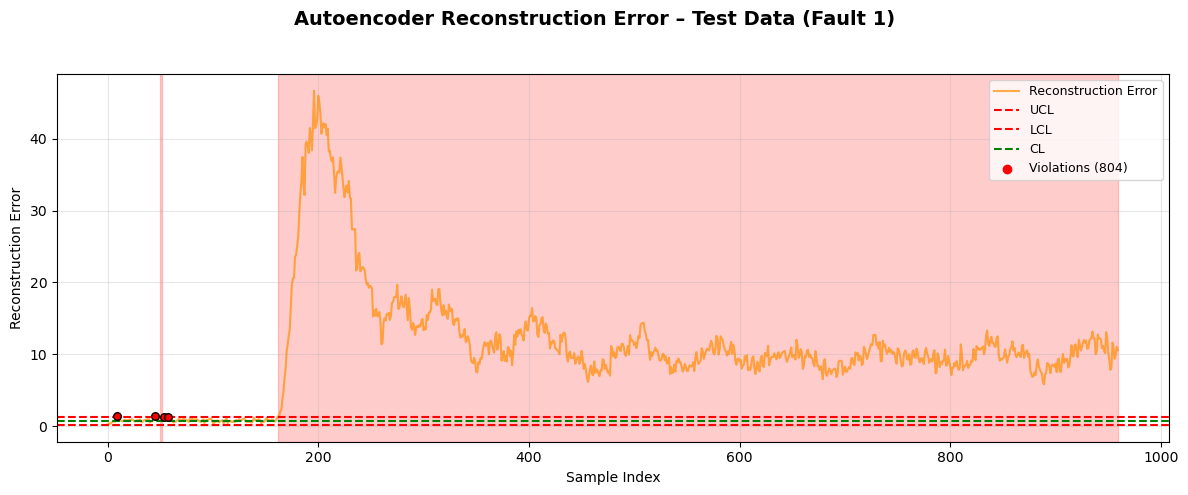

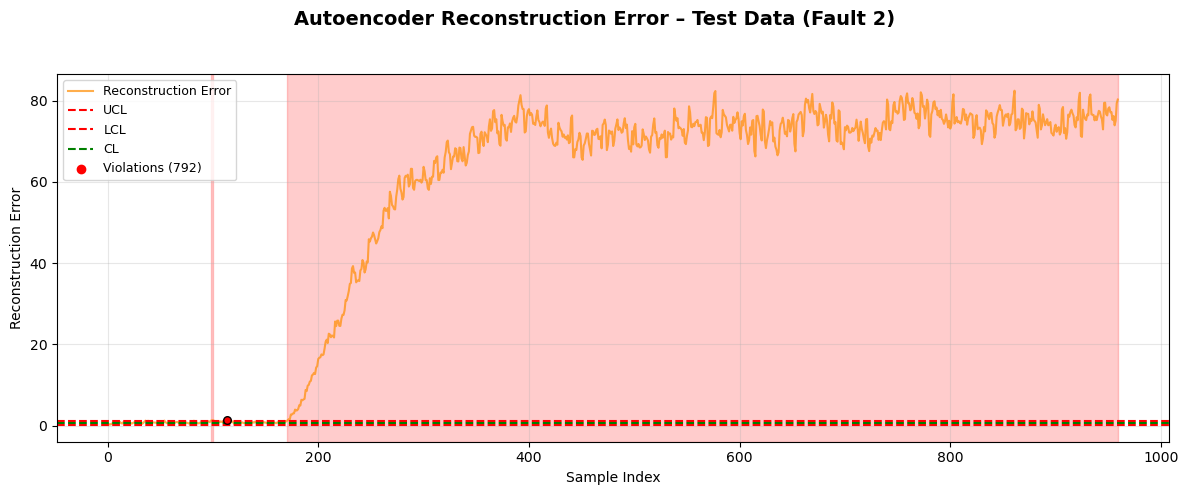

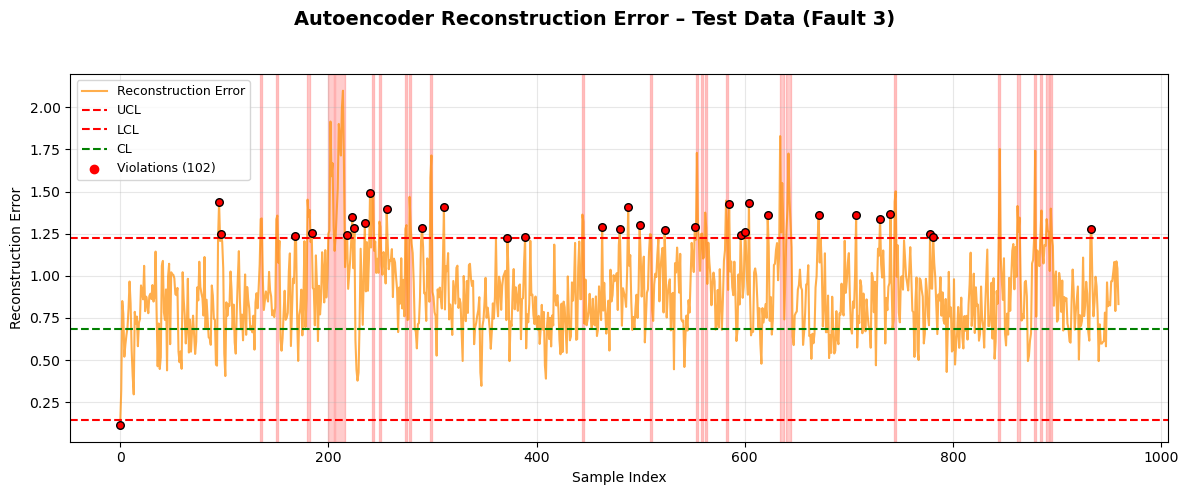

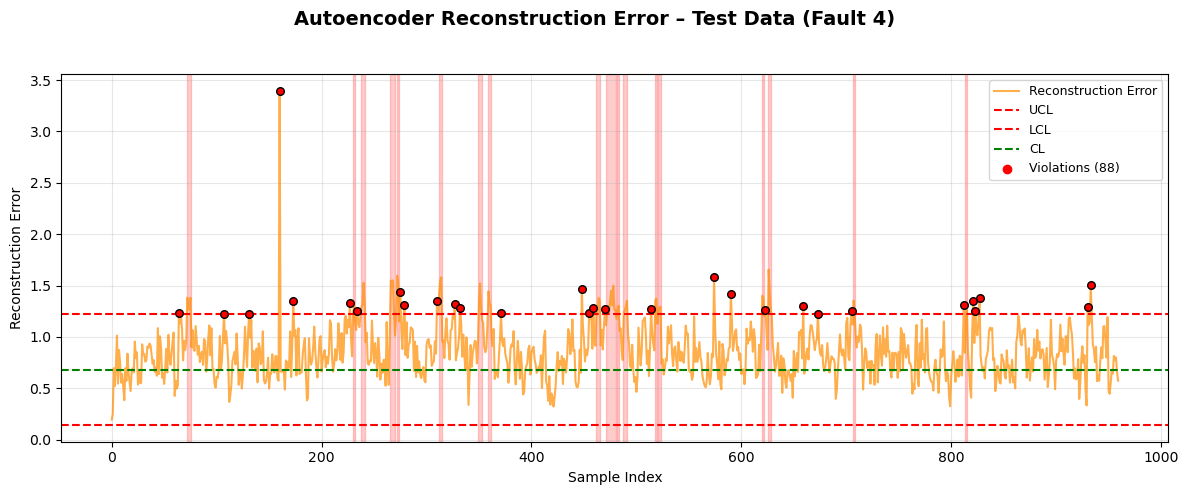

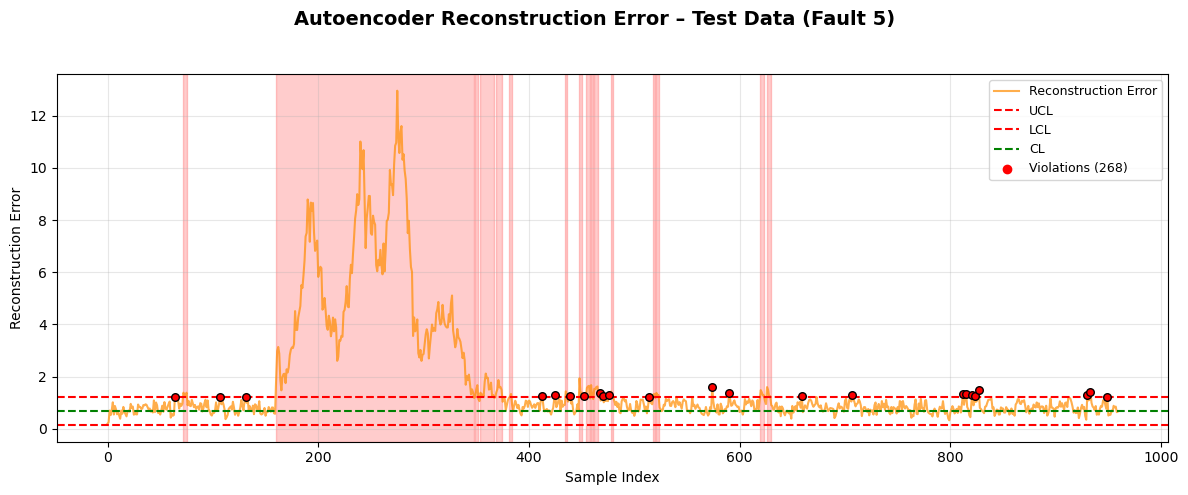

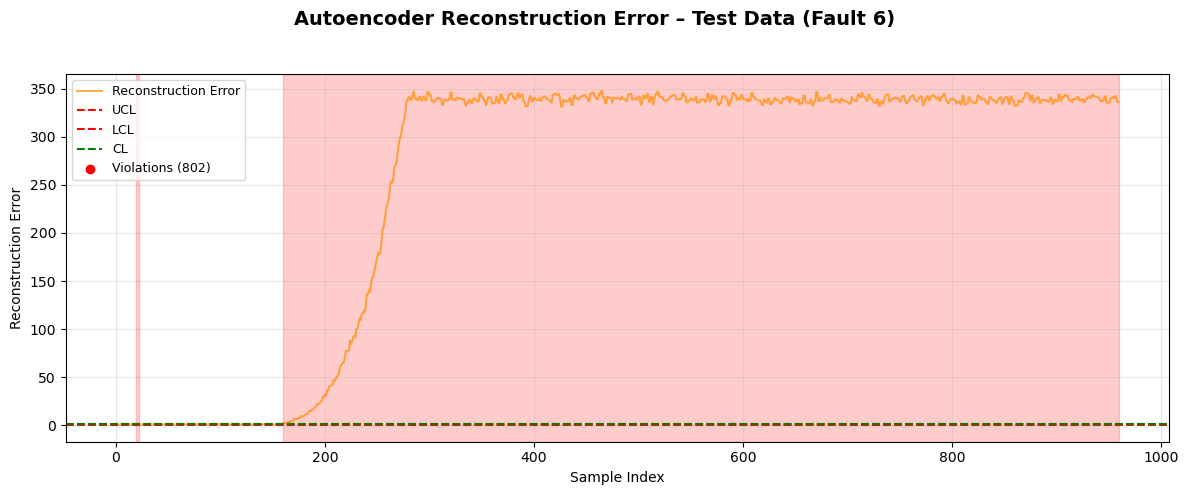

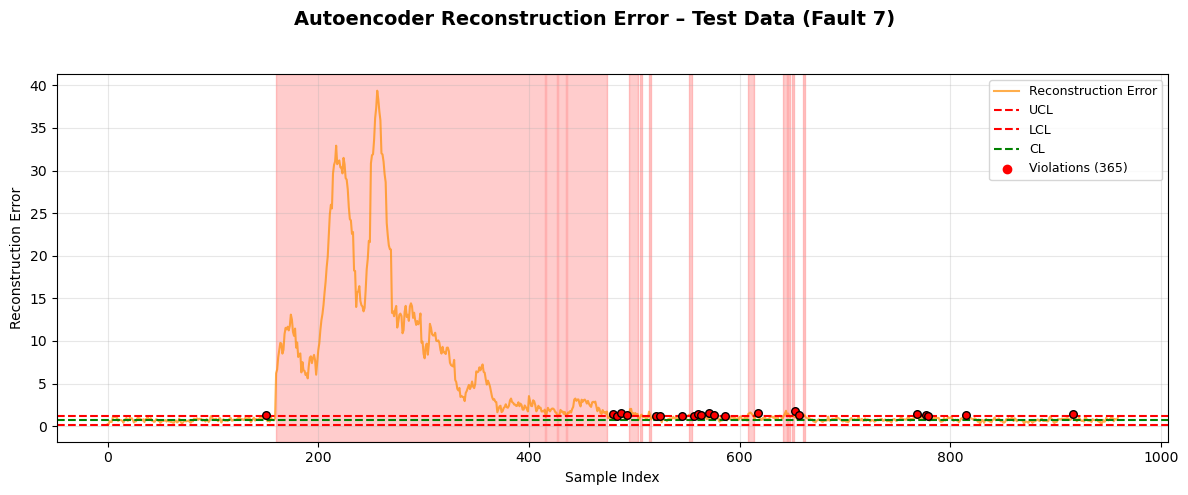

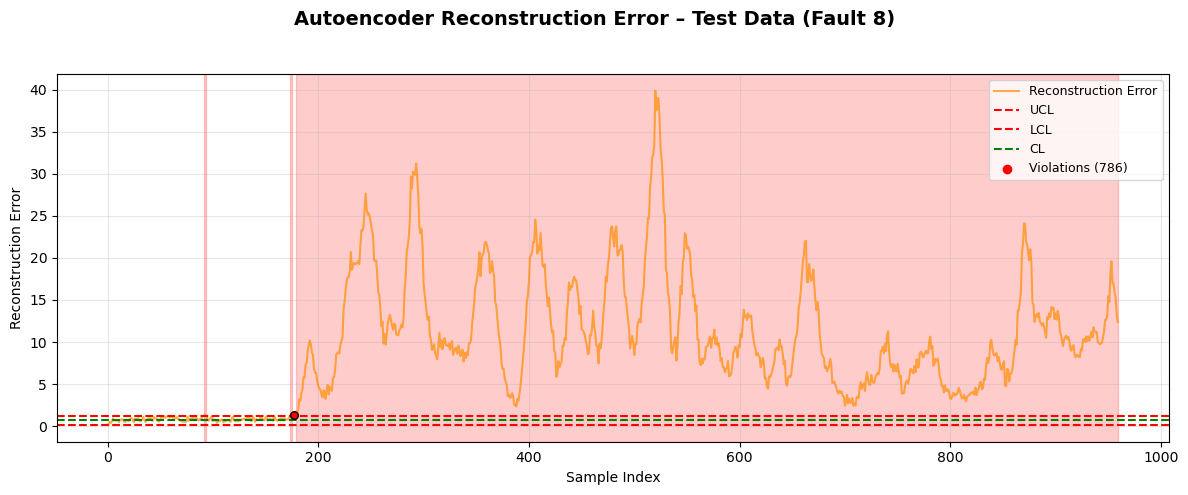

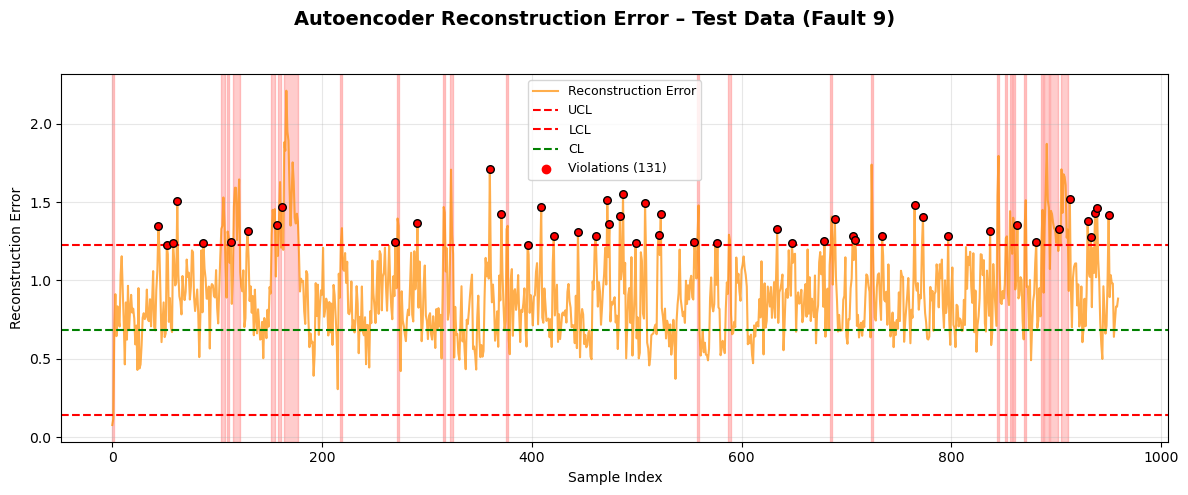

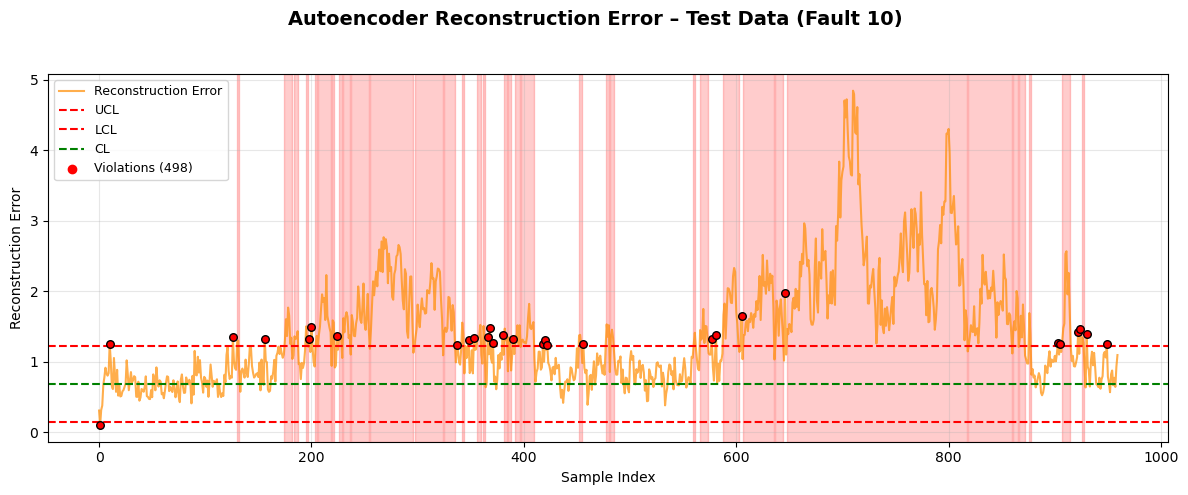

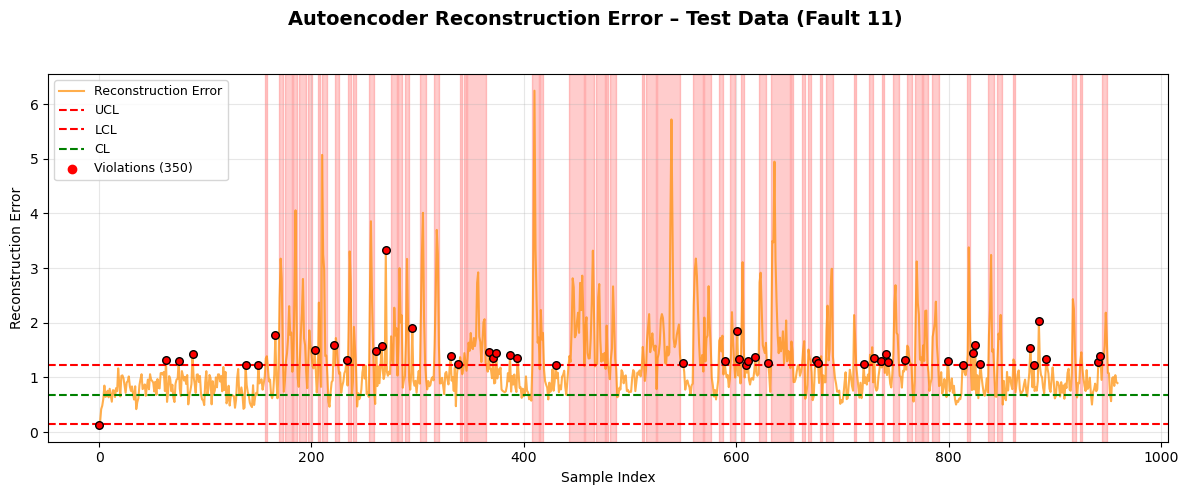

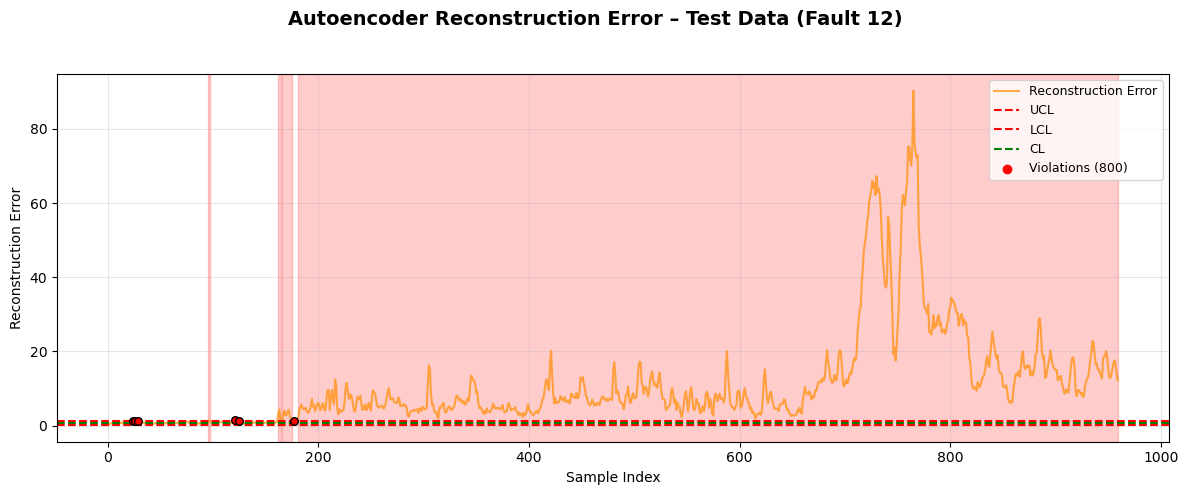

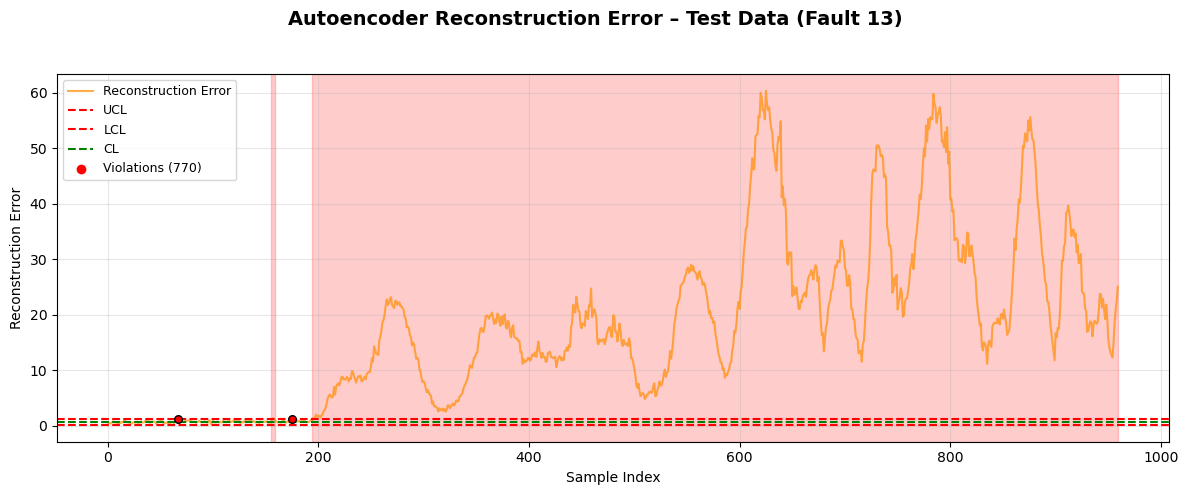

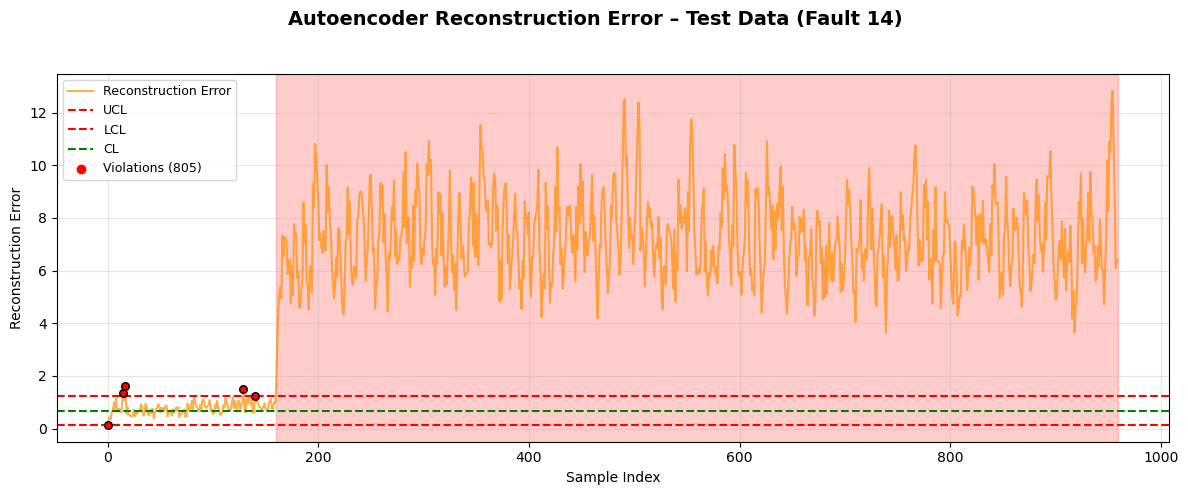

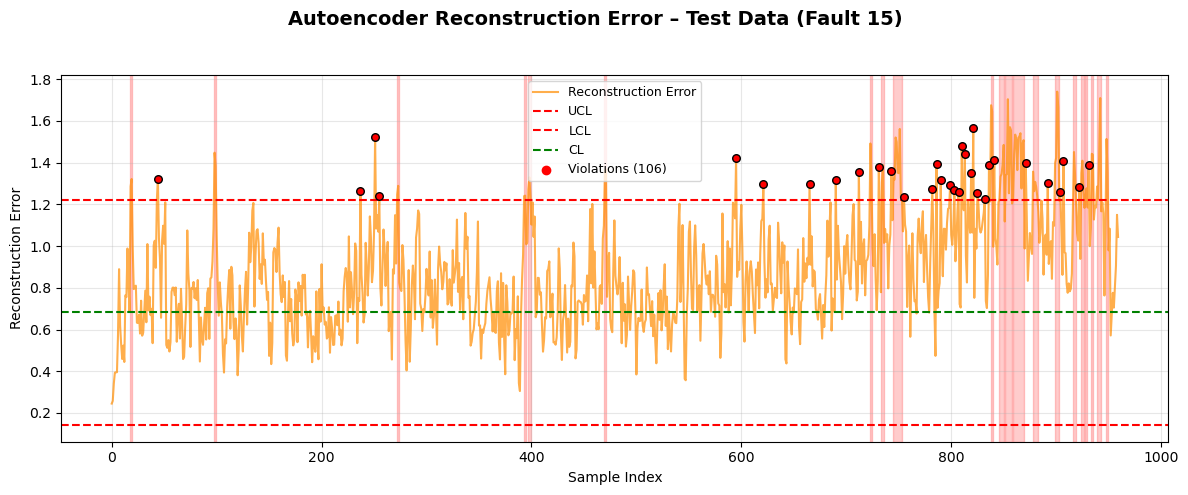

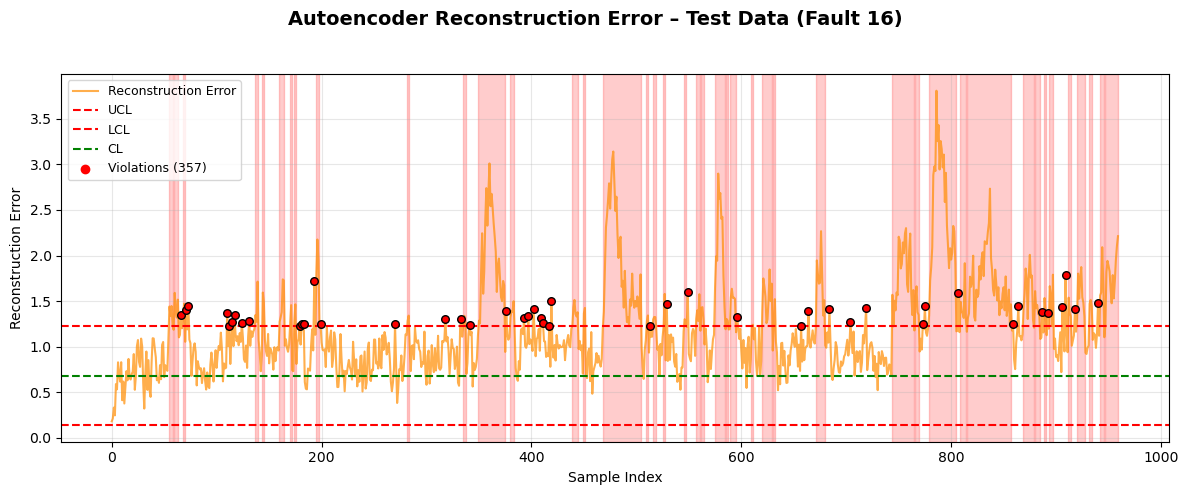

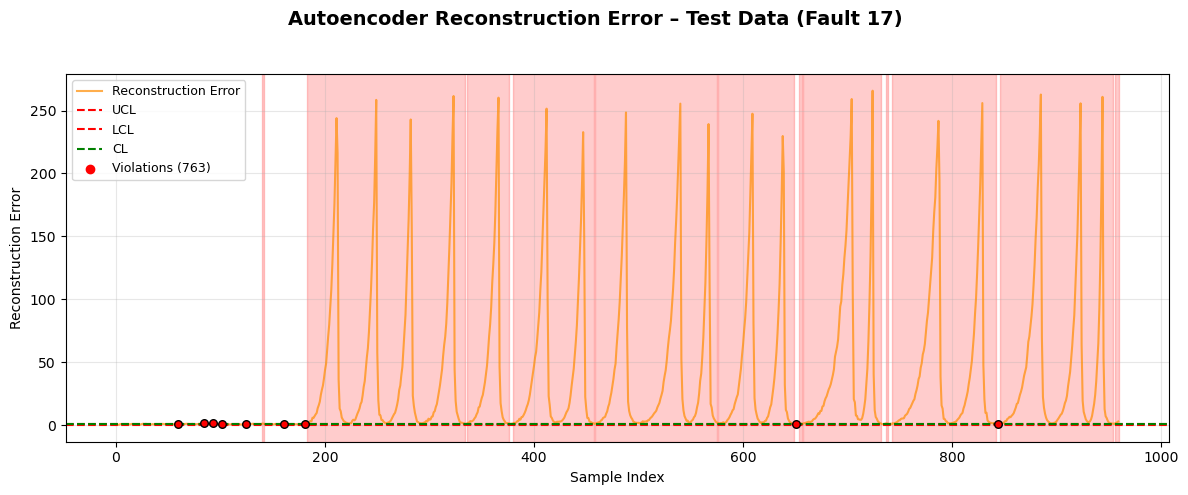

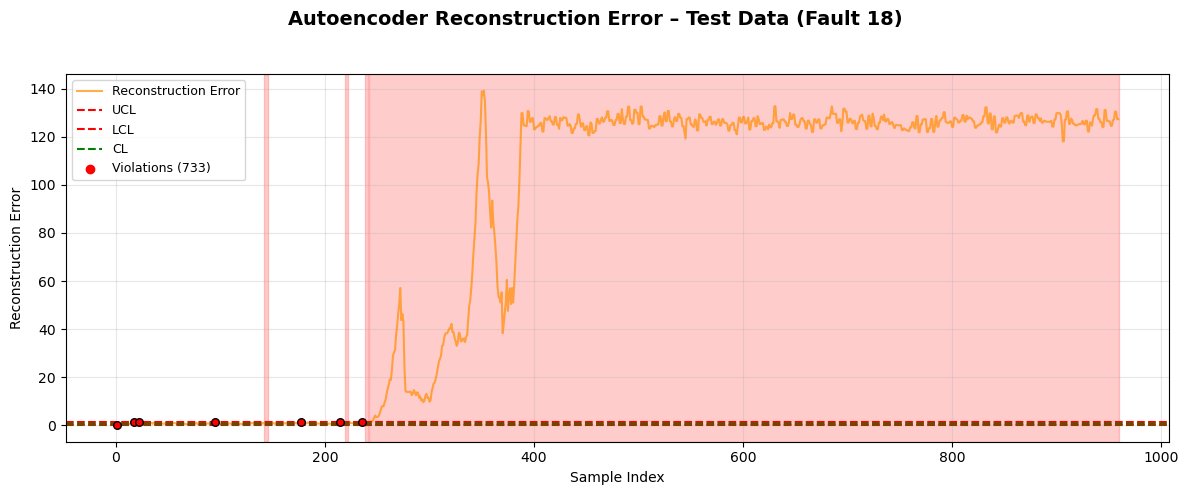

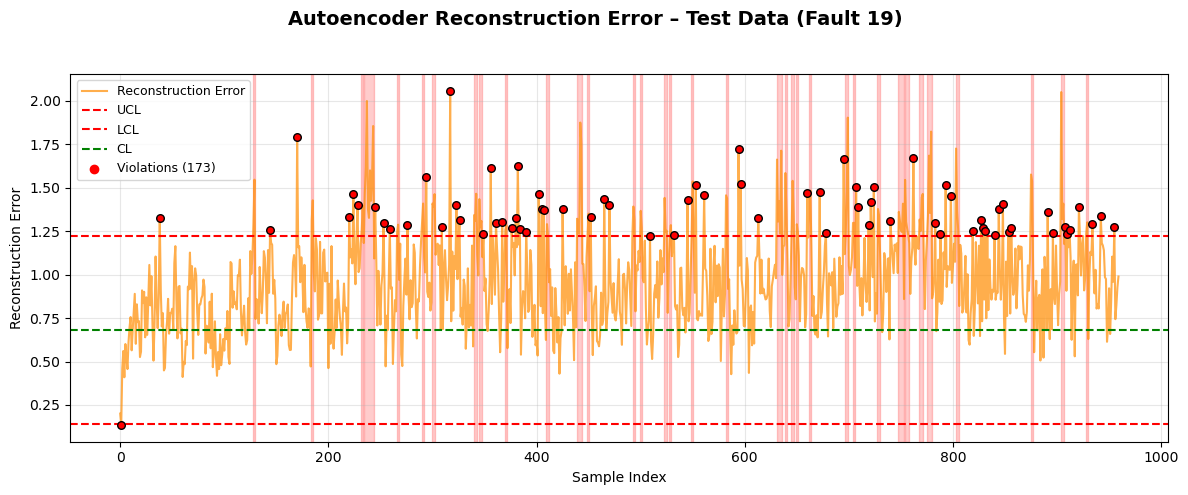

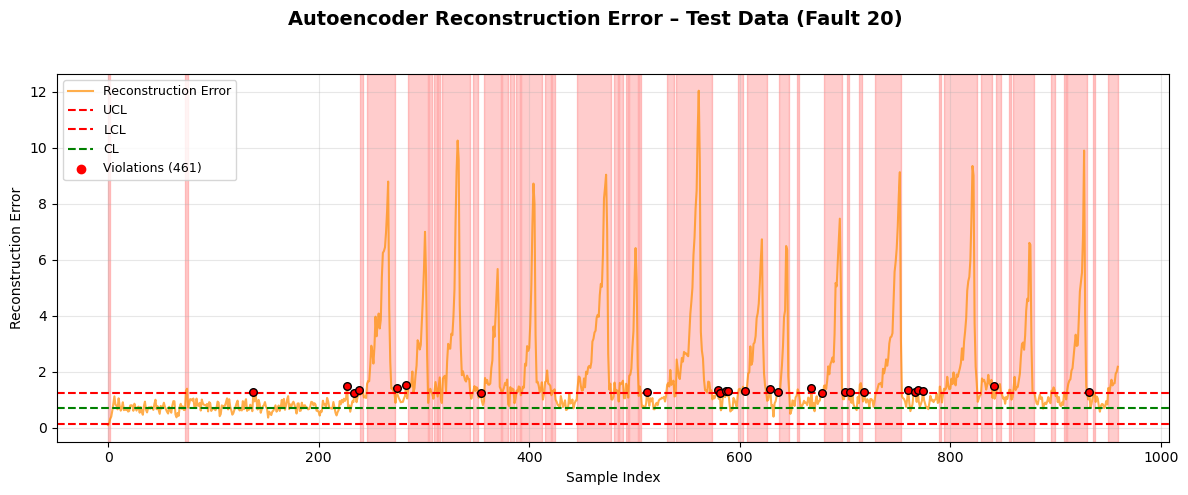

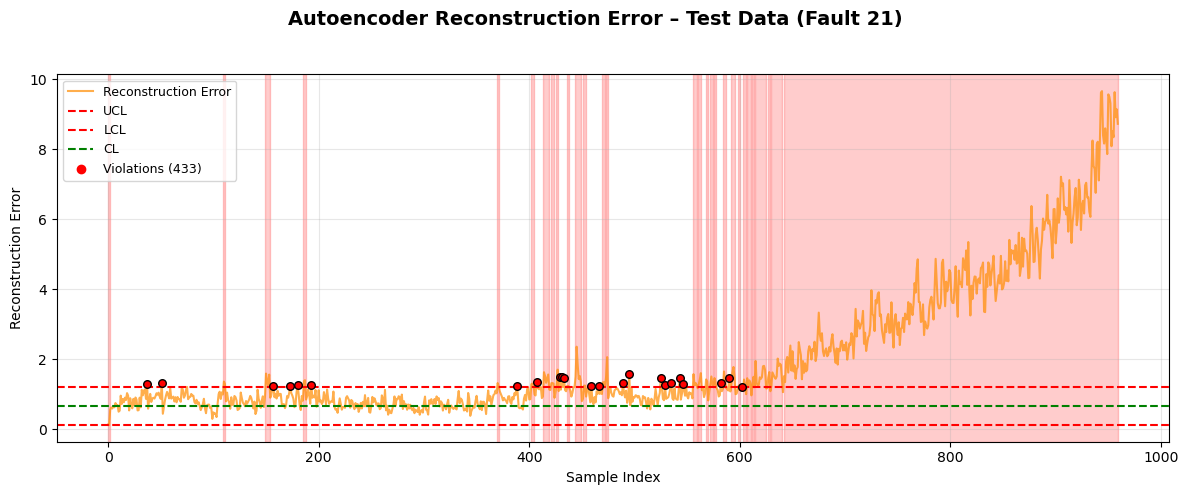

In [60]:
L_tests = {
    "Fault 1": L_test_1,
    "Fault 2": L_test_2,
    "Fault 3": L_test_3,
    "Fault 4": L_test_4,
    "Fault 5": L_test_5,
    "Fault 6": L_test_6,
    "Fault 7": L_test_7,
    "Fault 8": L_test_8,
    "Fault 9": L_test_9,
    "Fault 10": L_test_10,
    "Fault 11": L_test_11,
    "Fault 12": L_test_12,
    "Fault 13": L_test_13,
    "Fault 14": L_test_14,
    "Fault 15": L_test_15,
    "Fault 16": L_test_16,
    "Fault 17": L_test_17,
    "Fault 18": L_test_18,
    "Fault 19": L_test_19,
    "Fault 20": L_test_20,
    "Fault 21": L_test_21
}

BASE_DIR = os.getcwd()

for fault_name, L_test in L_tests.items():
    FAULT_DIR = os.path.join(BASE_DIR, "figures", fault_name)
    plot_RE_Monitoring(L_test, UCL, LCL, FAULT_DIR, FAULT_NAME=fault_name)


---

## Συνολικά διαγράμματα

train

In [136]:
detection_stats_train = pd.concat([detection_stats_train_pca, detection_stats_train_RE], axis = 1)

In [137]:
col = "AE_detection_rate"
new_pos = 2

cols = detection_stats_train.columns.tolist()
cols.insert(new_pos, cols.pop(cols.index(col)))
detection_stats_train = detection_stats_train[cols]

test

In [138]:
detection_stats_faults = pd.concat([detection_stats_faults_pca, detection_stats_faults_RE.drop("Fault", axis = 1)], axis = 1)

In [139]:
col = "AE_detection_rate"
new_pos = 3

cols = detection_stats_faults.columns.tolist()
cols.insert(new_pos, cols.pop(cols.index(col)))
detection_stats_faults = detection_stats_faults[cols]

In [140]:
detection_stats_faults

Fault  T2_detection_rate  Q_detection_rate  AE_detection_rate  \
0      1           0.840625          0.852083           0.837500   
0      2           0.828125          0.860417           0.825000   
0      3           0.112500          0.307292           0.106250   
0      4           0.077083          0.208333           0.091667   
0      5           0.284375          0.364583           0.279167   
0      6           0.834375          0.857292           0.835417   
0      7           0.393750          0.507292           0.380208   
0      8           0.818750          0.831250           0.818750   
0      9           0.115625          0.283333           0.136458   
0     10           0.456250          0.725000           0.518750   
0     11           0.422917          0.369792           0.364583   
0     12           0.836458          0.850000           0.833333   
0     13           0.800000          0.838542           0.802083   
0     14           0.839583          0.878125           0.838542   
0     15           0.133333          0.289583           0.110417   
0     16           0.381250          0.518750           0.371875   
0     17           0.761458          0.876042           0.794792   
0     18           0.756250          0.821875           0.763542   
0     19           0.194792          0.341667           0.180208   
0     20           0.379167          0.628125           0.480208   
0     21           0.412500          0.659375           0.451042   

   T2_num_violations  Q_num_violations  AE_num_violations  
0                807               818                804  
0                795               826                792  
0                108               295                102  
0                 74               200                 88  
0                273               350                268  
0                801               823                802  
0                378               487                365  
0                786               798                786  
0                111               272                131  
0                438               696                498  
0                406               355                350  
0                803               816                800  
0                768               805                770  
0                806               843                805  
0                128               278                106  
0                366               498                357  
0                731               841                763  
0                726               789                733  
0                187               328                173  
0                364               603                461  
0                396               633                433

In [141]:
def detection_stats_table(df, title):
    """
    Displays the detection statistics DataFrame as a compact, styled table plot.
    """
    # Create a copy of the DataFrame for formatting
    df_display = df.copy()

    # Round detection rates to 4 decimals
    df_display['T2_detection_rate'] = df_display['T2_detection_rate'].apply(lambda x: f"{x:.4f}")
    df_display['Q_detection_rate'] = df_display['Q_detection_rate'].apply(lambda x: f"{x:.4f}")
    df_display['AE_detection_rate'] = df_display['AE_detection_rate'].apply(lambda x: f"{x:.4f}")

    # Format number of violations as integers with commas
    df_display['T2_num_violations'] = df_display['T2_num_violations'].apply(lambda x: f"{int(x):,}")
    df_display['Q_num_violations'] = df_display['Q_num_violations'].apply(lambda x: f"{int(x):,}")
    df_display['AE_num_violations'] = df_display['AE_num_violations'].apply(lambda x: f"{int(x):,}")

    # Set figure height dynamically based on number of rows
    n_rows = len(df_display)
    fig_height = max(2, 0.3 * n_rows)  # δυναμικό ύψος ανά γραμμή
    fig, ax = plt.subplots(figsize=(12, fig_height))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Create table
    table = ax.table(
        cellText=df_display.values,
        colLabels=df_display.columns,   
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)  # make table more compact

    # Bold header row
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # header row
            cell.set_text_props(fontweight='bold')


    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the table figure
    filename = title.replace(" ", "_").replace("-", "") + ".png"
    fig.savefig(os.path.join(FIG_DIR, filename),
            dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

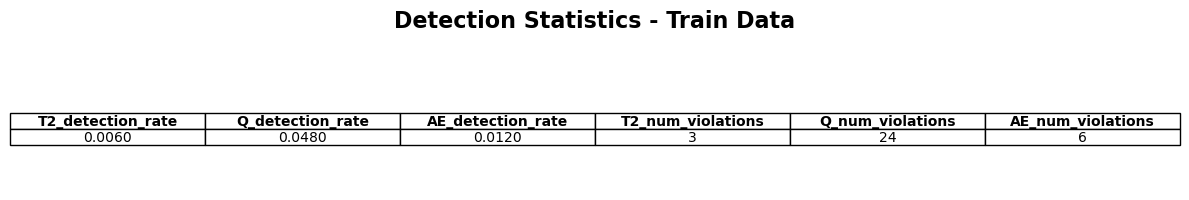

In [142]:
detection_stats_table(detection_stats_train, title="Detection Statistics - Train Data")

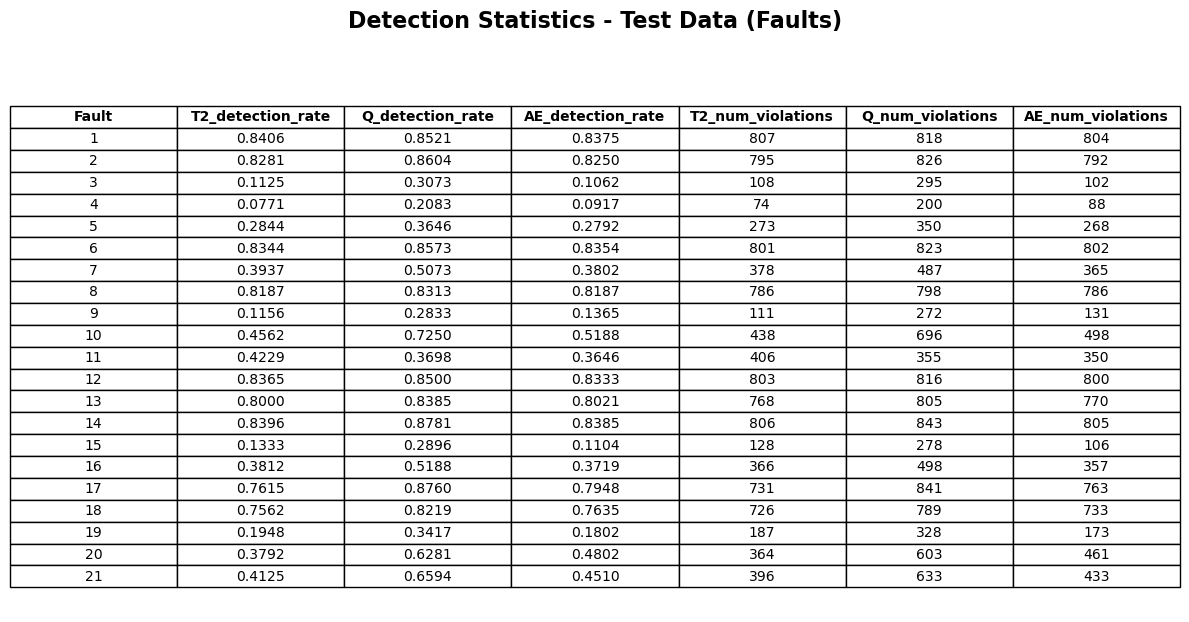

In [143]:
detection_stats_table(detection_stats_faults, title="Detection Statistics - Test Data (Faults)")

---

## Κριτήρια Αξιολόγησης

False Alarm Rate (Φάση I)

In [31]:
def false_alarm_rate(stat_train, UCL, LCL=None):
    """
    Computes the false alarm rate for training data based on control limits.
    """
    # Determine which samples exceed control limits
    if LCL is None:
        alarms = stat_train > UCL
    else:
        alarms = (stat_train > UCL) | (stat_train < LCL)
    # Return the fraction of samples that triggered an alarm
    return np.sum(alarms) / len(stat_train)

In [32]:
FAR_T2 = false_alarm_rate(T2_train, T2_limit)
FAR_Q  = false_alarm_rate(Q_train, Q_limit)
FAR_AE = false_alarm_rate(L_train, UCL, LCL)

Fault Detection Rate (Φάση II)

In [33]:
def fault_detection_rate(stat_test, UCL, fault_start, LCL=None):
    """
    Computes the fault detection rate for test data starting from the fault onset.
    """
    # Select only the data after the fault starts
    stat_fault = stat_test[fault_start:]
    
    # Determine which samples exceed control limits
    if LCL is None:
        detected = stat_fault > UCL
    else:
        detected = (stat_fault > UCL) | (stat_fault < LCL)

    # Return the fraction of samples detected as faults
    return np.sum(detected) / len(stat_fault)

In [34]:
fault_start = 160

Detection Delay

In [35]:
def detection_delay(stat_test, UCL, fault_start, LCL=None):
    """
    Computes the detection delay, i.e., the number of samples after the fault onset
    until the statistic first exceeds the control limits.
    """
    # Select data after fault onset
    post_fault = stat_test[fault_start:]

    # Find indices where the statistic exceeds control limits
    if LCL is None:
        exceed = np.where(post_fault > UCL)[0]
    else:
        exceed = np.where((post_fault > UCL) | (post_fault < LCL))[0]

    # Return the first index of detection, or infinity if not detected
    if len(exceed) == 0:
        return np.inf  # fault not detected
    else:
        return exceed[0]

---

## Διαγράμματα Κριτηρίων Αξιολόγησης

## Σύγκριση PCA και Autoencoder στα train data

In [36]:
methods = ["T2", "Q", "AE"]

FAR = [FAR_T2, FAR_Q, FAR_AE]

In [37]:
FAR_df = pd.DataFrame({
    "Method": methods,
    "FAR": FAR
})

In [38]:
FAR_df

Method    FAR
0     T2  0.006
1      Q  0.048
2     AE  0.012

In [39]:
def metrics_table_FAR(df, title):
    """
    Displays a FAR table (Method vs FAR) with the same format as metrics_table.
    """
    df_display = df.copy()

    # Format FAR values
    df_display['FAR'] = df_display['FAR'].apply(lambda x: f"{x:.4f}")

    # Set figure height dynamically based on number of rows
    n_rows = len(df_display)
    fig_height = max(2, 0.3 * n_rows)

    fig, ax = plt.subplots(figsize=(12, fig_height))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Create table
    table = ax.table(
        cellText=df_display.values,
        colLabels=df_display.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)

    # Bold header row
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(fontweight='bold')

    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the table figure
    filename = title.replace(" ", "_").replace("-", "") + ".png"
    fig.savefig(
        os.path.join(FIG_DIR, filename),
        dpi=300,
        bbox_inches="tight"
    )

    plt.show()
    plt.close(fig)


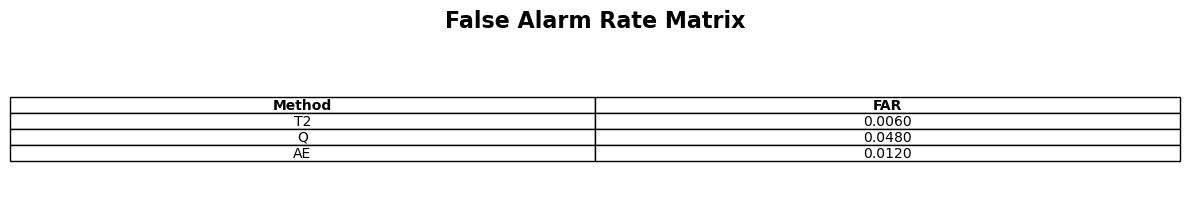

In [40]:
metrics_table_FAR(
    FAR_df,
    title="False Alarm Rate Matrix"
)

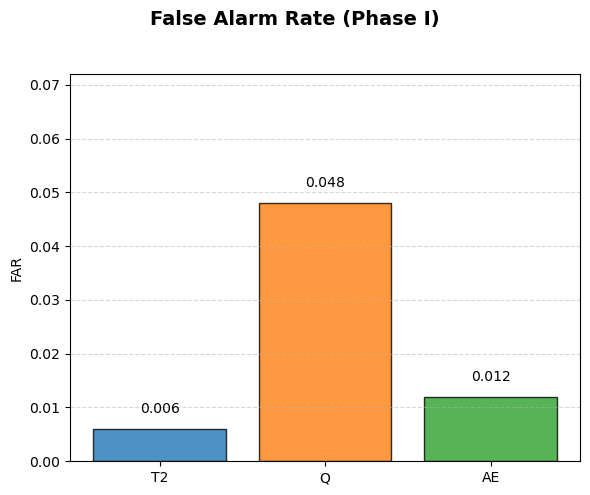

In [43]:
fig, ax = plt.subplots(figsize=(6, 5))
fig.suptitle("False Alarm Rate (Phase I)", fontsize=14, fontweight='bold')

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Χρώματα για κάθε μέθοδο

# Create bar plot
bars = ax.bar(methods, FAR, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel("FAR")
ax.set_ylim(0, max(FAR)*1.5)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + max(FAR)*0.05, f"{height}",
            ha='center', va='bottom', fontsize=10)
    
# Adjust layout, save, and show figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # αφήνει χώρο για το suptitle
fig.savefig(os.path.join(FIG_DIR, "False_Alarm_Rate.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

## Σύγκριση PCA και Autoencoder στα test data

In [156]:
def compute_FDR_and_DD(T2_tests, Q_tests, L_tests, T2_limit, Q_limit, UCL, LCL, fault_start=160):
    """
    Computes the Fault Detection Rate (FDR) and Detection Delay (DD) for all faults
    across T², Q, and autoencoder statistics.
    """
    all_folds_metrics = []

    for fault in range(1, 22): 
        fault_start = 160  
    
        # Retrieve test data for the current fault using global variables
        T2_test = globals()[f"T2_test_{fault}"]
        Q_test  = globals()[f"Q_test_{fault}"]
        L_test  = globals()[f"L_test_{fault}"]

        # Compute Fault Detection Rate for each method
        FDR_T2 = fault_detection_rate(T2_test, T2_limit, fault_start)
        FDR_Q  = fault_detection_rate(Q_test, Q_limit, fault_start)
        FDR_AE = fault_detection_rate(L_test, UCL, fault_start, LCL)

        # Compute Detection Delay for each method
        DD_T2 = detection_delay(T2_test, T2_limit, fault_start)
        DD_Q  = detection_delay(Q_test, Q_limit, fault_start)
        DD_AE = detection_delay(L_test, UCL, fault_start, LCL)
    
        # Store results for the current fault
        all_folds_metrics.append({
            "Fault": fault,
            "FDR_T2": FDR_T2,
            "FDR_Q": FDR_Q,
            "FDR_AE": FDR_AE,
            "DD_T2": DD_T2,
            "DD_Q": DD_Q,
            "DD_AE": DD_AE
        })

    return pd.DataFrame(all_folds_metrics)

In [157]:
metrics_df = compute_FDR_and_DD(T2_tests, Q_tests, L_tests, T2_limit, Q_limit, UCL, LCL, fault_start=160)

In [158]:
metrics_df

Fault   FDR_T2    FDR_Q   FDR_AE  DD_T2  DD_Q  DD_AE
0       1  0.99375  0.99875  0.99750      4     1      2
1       2  0.98625  0.99875  0.98625     11     0     11
2       3  0.11750  0.32250  0.11875      2     1      8
3       4  0.08125  0.20875  0.10125      0     0      0
4       5  0.33000  0.39625  0.32625      0     0      0
5       6  1.00000  1.00000  1.00000      0     0      0
6       7  0.47125  0.56625  0.45500      0     0      0
7       8  0.97500  0.96375  0.98000     14     6     14
8       9  0.10750  0.28250  0.13000      0     0      0
9      10  0.54375  0.82875  0.61500      5     0     15
10     11  0.49625  0.40000  0.42750      6     3      6
11     12  0.99250  0.98375  0.99125      1     3      2
12     13  0.95750  0.97125  0.95750      7    12     15
13     14  1.00000  0.99750  1.00000      0     0      0
14     15  0.15125  0.31375  0.12625     90     2     77
15     16  0.41750  0.58000  0.41625      0    14      0
16     17  0.91000  0.97750  0.94500      1     7      1
17     18  0.90250  0.93750  0.90625      3     6     17
18     19  0.22375  0.37875  0.21000     10     5     10
19     20  0.45125  0.72750  0.57000     67     4     67
20     21  0.47875  0.72250  0.52750     12     1     13

In [153]:
def metrics_table(df, title):
    """
    Displays a metrics DataFrame (e.g., FDR values) as a compact, styled table plot.
    """
    # Create a copy of the DataFrame for formatting
    df_display = df.copy()

    # Round Fault Detection Rates to 4 decimals
    df_display['FDR_T2'] = df_display['FDR_T2'].apply(lambda x: f"{x:.4f}")
    df_display['FDR_Q'] = df_display['FDR_Q'].apply(lambda x: f"{x:.4f}")
    df_display['FDR_AE'] = df_display['FDR_AE'].apply(lambda x: f"{x:.4f}")

    # Set figure height dynamically based on number of rows
    n_rows = len(df_display)
    fig_height = max(2, 0.3 * n_rows)  
    fig, ax = plt.subplots(figsize=(12, fig_height))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Create table
    table = ax.table(
        cellText=df_display.values,
        colLabels=df_display.columns,   
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2) 

    # Bold header row
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # header row
            cell.set_text_props(fontweight='bold')
    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the table figure
    filename = title.replace(" ", "_").replace("-", "") + ".png"
    fig.savefig(os.path.join(FIG_DIR, filename),
            dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

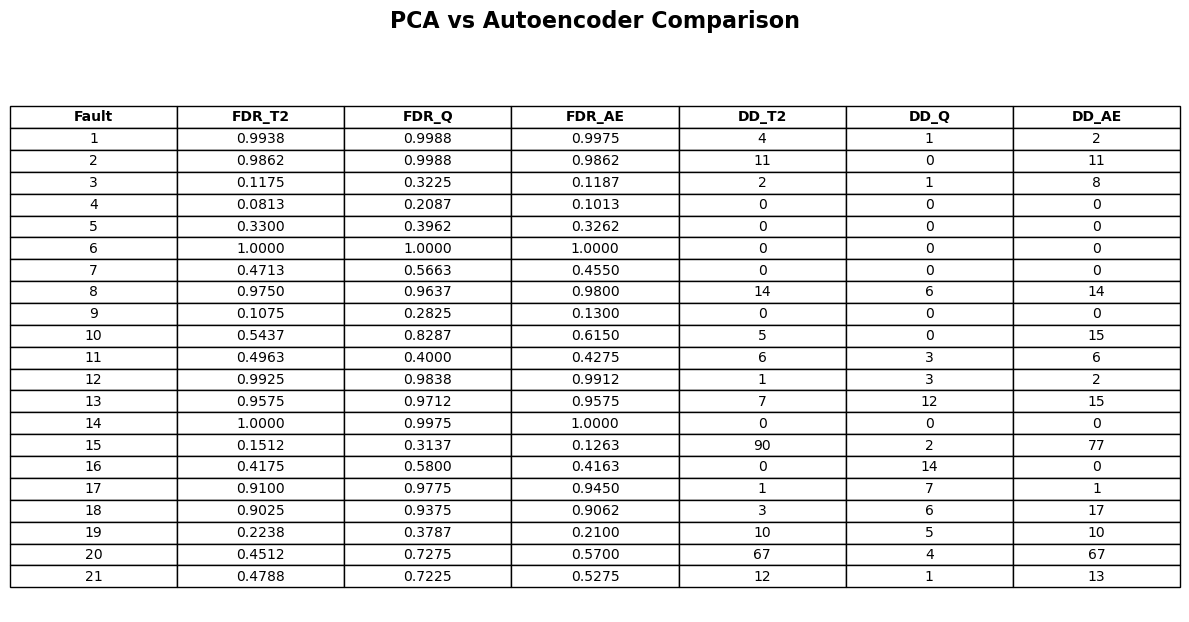

In [88]:
metrics_table(metrics_df, title = "PCA vs Autoencoder Comparison")

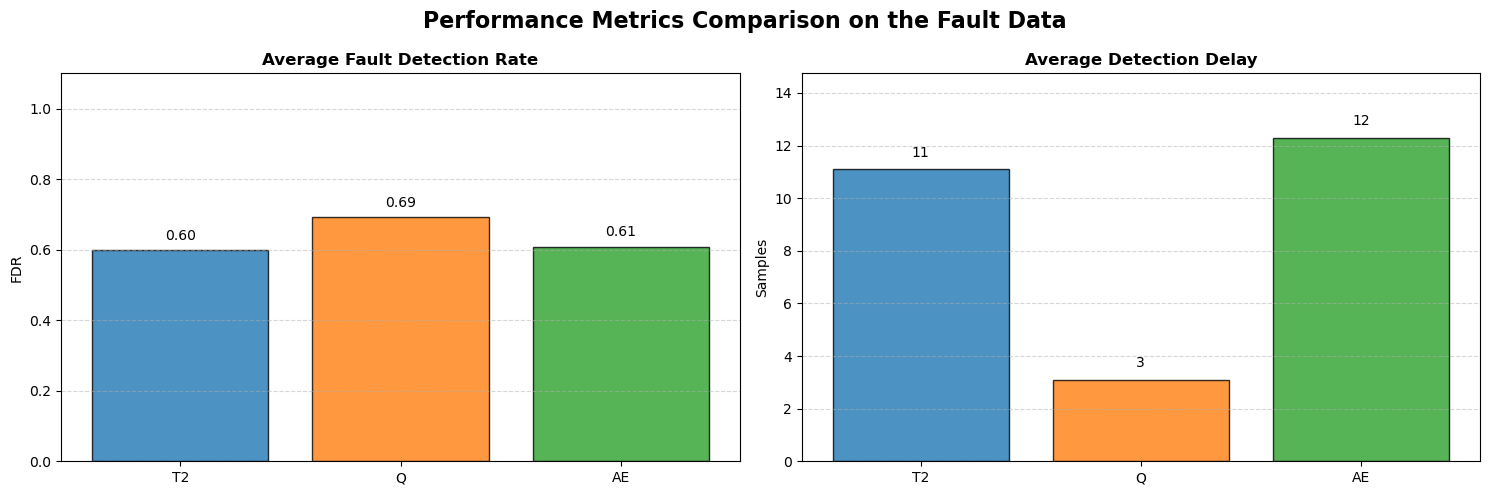

In [89]:
#methods = ["T2", "Q", "AE"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Compute mean FDR and mean Detection Delay for each method
mean_FDR = [metrics_df[f"FDR_{m}"].mean() for m in methods]
mean_DD  = [metrics_df[f"DD_{m}"].mean() for m in methods]

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Performance Metrics Comparison on the Fault Data", fontsize=16, fontweight='bold')


# --- FDR barplot ---
bars = axes[0].bar(methods, mean_FDR, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_title("Average Fault Detection Rate",  fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel("FDR")
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=10)

# --- Detection Delay barplot ---
bars = axes[1].bar(methods, mean_DD, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_title("Average Detection Delay",  fontsize=12, fontweight='bold')
axes[1].set_ylabel("Samples")
axes[1].grid(axis="y", linestyle="--", alpha=0.5)
axes[1].set_ylim(0, max(mean_DD)*1.2)

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + max(mean_DD)*0.03, f"{height:.0f}", 
                 ha='center', va='bottom', fontsize=10)
    
# Adjust layout, save, and show figure
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "Performance_Metrics_Comparison.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)